In [1]:
import os
os.chdir('/home/ssobti/projects/mir_tud/packages/ciberatac-main/src/mave')
import pandas as pd
import numpy as np
import scanpy as sc
import itertools
import pickle
import shelve

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.4 scipy==1.9.3 pandas==1.5.1 scikit-learn==1.1.3 statsmodels==0.13.5 pynndescent==0.5.8


In [3]:
adata = sc.read('/home/ssobti/projects/mir_tud/110222_filtered_data/miR.concat.raw.adata_gex.guide_assigned.h5')

Only considering the two last: ['.guide_assigned', '.h5'].
Only considering the two last: ['.guide_assigned', '.h5'].


In [4]:
### feed in raw matrix (adata.X) into VAE with filter out cells with low # genes and genes expressed in low # of cells
adata.var_names_make_unique()

In [5]:
adata

AnnData object with n_obs × n_vars = 30035 × 36601
    obs: 'sample', 'barcode', 'guide', 'lor', 'pvalue', 'adj_pvalue', 'max_umi', 'n_umi', 'm_umi', 'v_umi', 'log_max_umi', 'log_n_umi', 'log_m_umi'
    var: 'feature_type'

normalizing counts per cell
    finished (0:00:01)


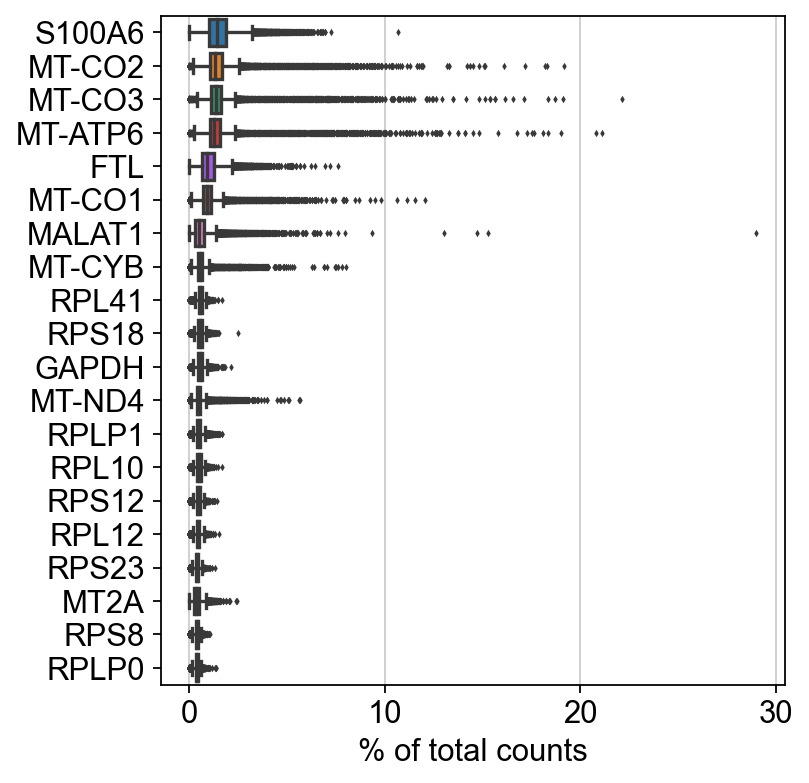

In [6]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 1 cells that have less than 200 genes expressed
filtered out 6345 genes that are detected in less than 3 cells


In [8]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

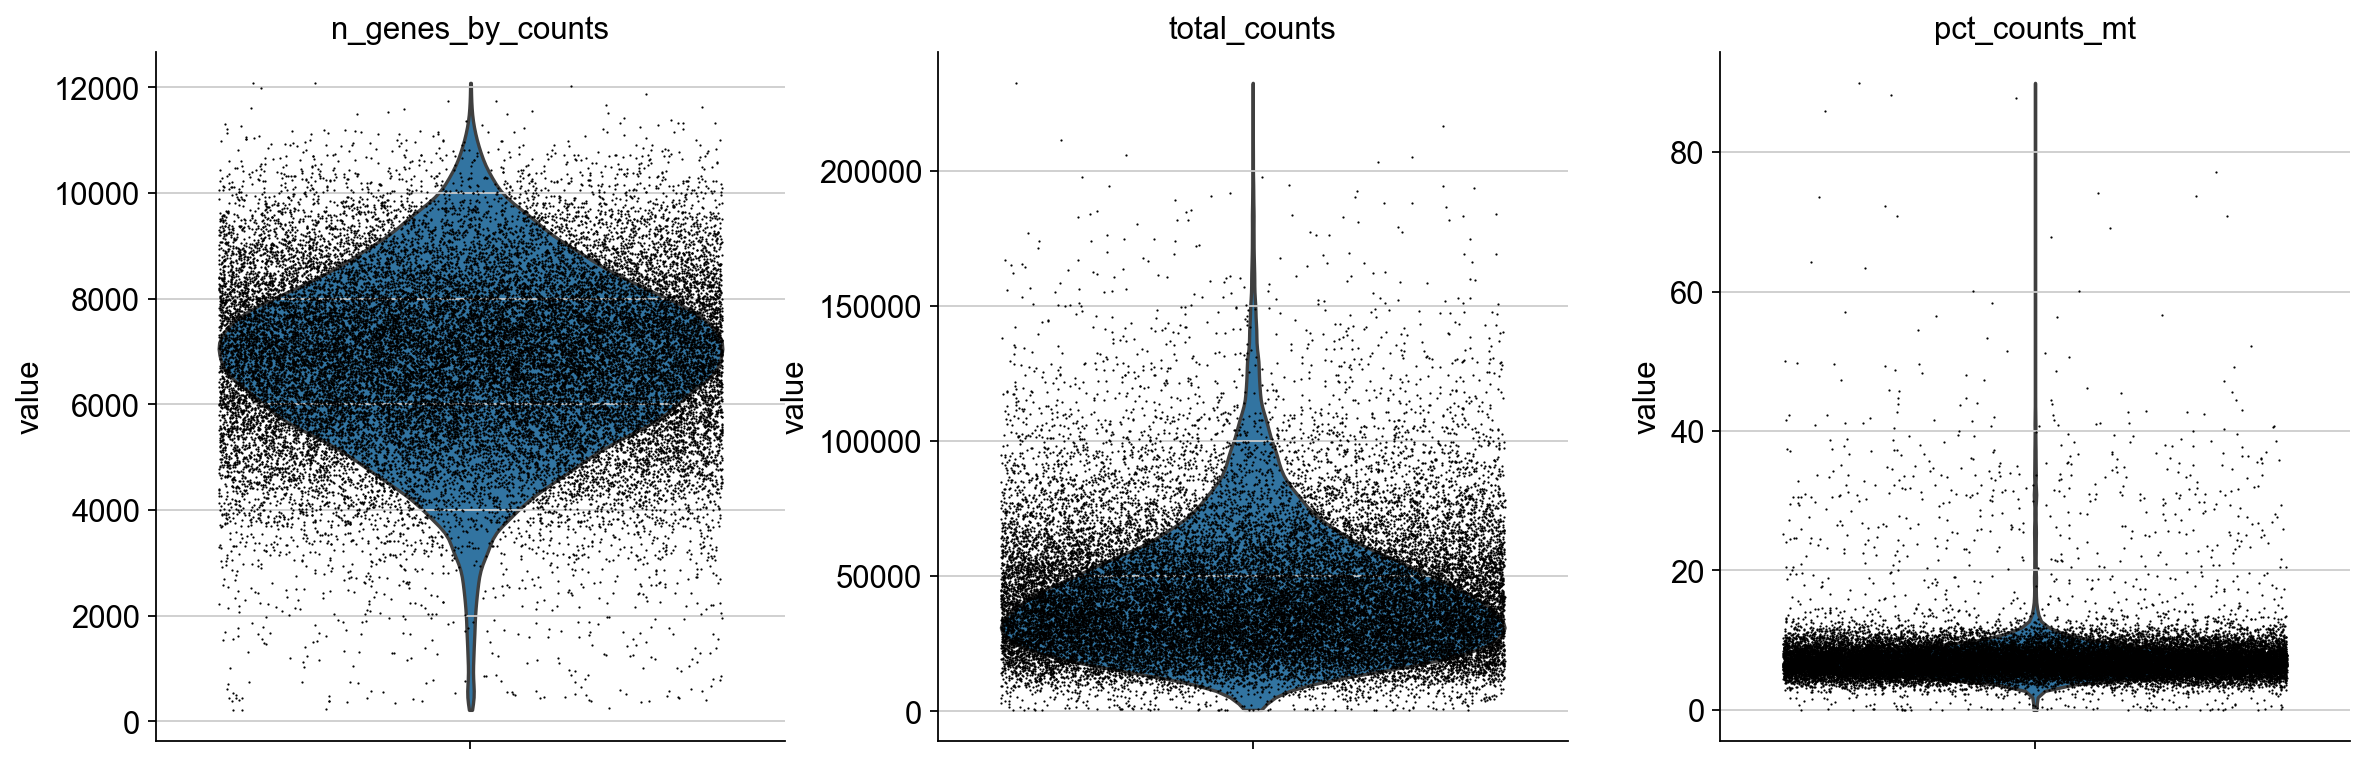

In [9]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

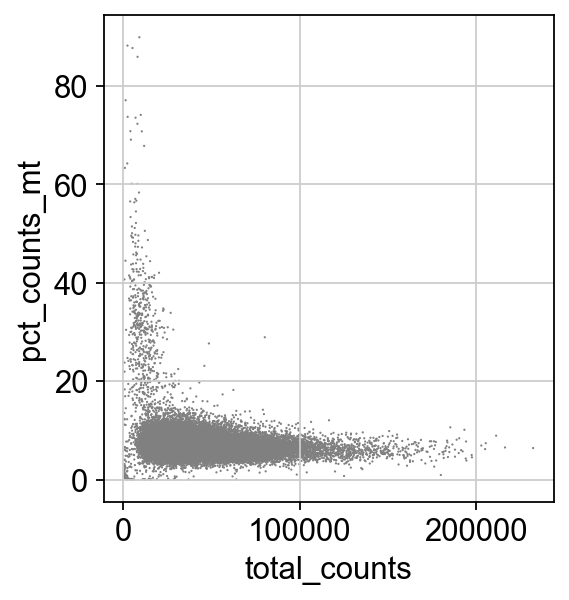

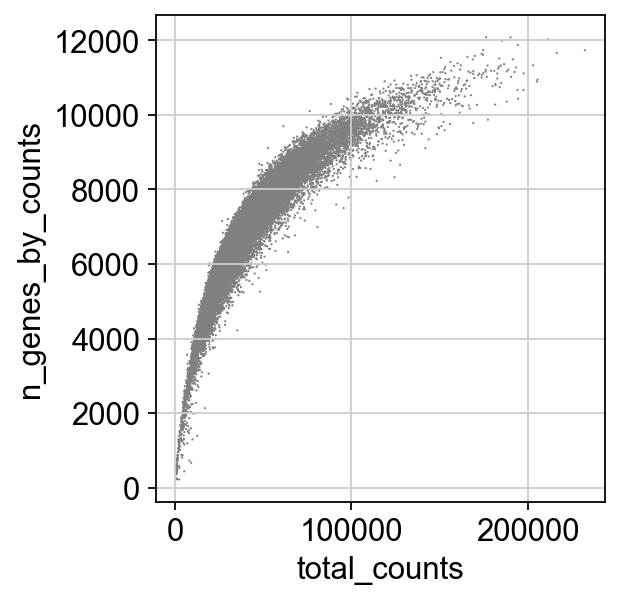

In [10]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt',)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [11]:
adata = adata[adata.obs.pct_counts_mt < 12, :]

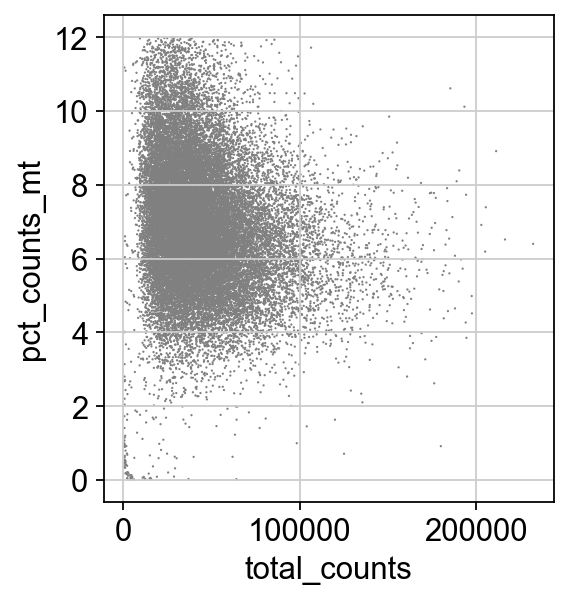

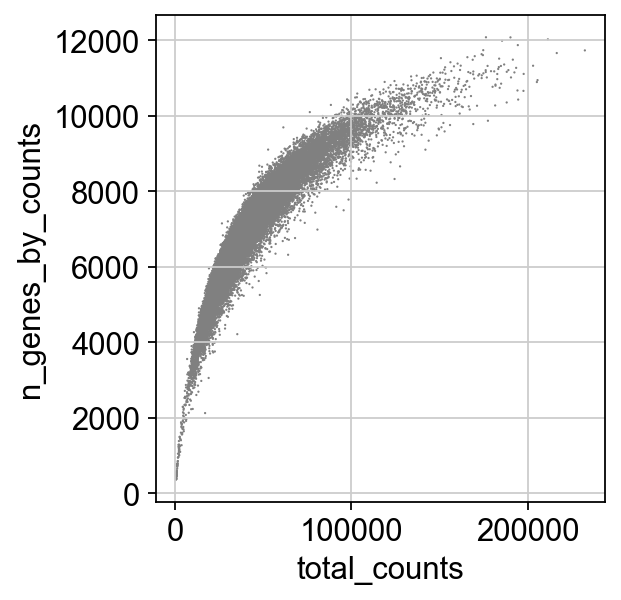

In [12]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt',)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [13]:
### remove ('hsa-miR-92a-3p', ['miR_1:TCACAAGTCGGCATAT-1']) from adata
cells_to_keep = [cell for cell in adata.obs.index.to_list() if cell != 'miR_1:TCACAAGTCGGCATAT-1']
adata = adata[cells_to_keep,:]

In [14]:
adata.obs

sample           barcode             guide       lor  \
miR_1:AAACCCAAGGAGAGGC-1  miR_1  AAACCCAAGGAGAGGC   hsa-miR-203a-3p  5.453121   
miR_1:AAACCCAAGGTAAACT-1  miR_1  AAACCCAAGGTAAACT     hsa-miR-93-3p  6.012001   
miR_1:AAACCCACAACGATCT-1  miR_1  AAACCCACAACGATCT   hsa-miR-130b-3p  5.864701   
miR_1:AAACCCACACGATTCA-1  miR_1  AAACCCACACGATTCA         TuD_NC_18  5.859895   
miR_1:AAACCCACAGTCAACT-1  miR_1  AAACCCACAGTCAACT   hsa-miR-147b-5p  5.632808   
...                         ...               ...               ...       ...   
miR_3:TTTGGTTTCGGACTTA-1  miR_3  TTTGGTTTCGGACTTA    hsa-miR-616-5p  3.885564   
miR_3:TTTGTTGCACGCGTGT-1  miR_3  TTTGTTGCACGCGTGT    hsa-miR-361-5p  0.506602   
miR_3:TTTGTTGCATAGATCC-1  miR_3  TTTGTTGCATAGATCC   hsa-miR-548o-3p  6.603449   
miR_3:TTTGTTGGTCTAGTGT-1  miR_3  TTTGTTGGTCTAGTGT   hsa-miR-3940-5p  2.402414   
miR_3:TTTGTTGGTTTCCATT-1  miR_3  TTTGTTGGTTTCCATT  hsa-miR-10527-5p  6.014592   

                                 pvalue     adj_pvalue  max_umi  n_umi  \
miR_1:AAACCCAAGGAGAGGC-1  2.983000e-159  3.010603e-152     67.0   78.0   
miR_1:AAACCCAAGGTAAACT-1  3.907611e-225  3.943769e-218     97.0  108.0   
miR_1:AAACCCACAACGATCT-1  3.299362e-202  3.329893e-195     89.0  113.0   
miR_1:AAACCCACACGATTCA-1  2.574602e-201  2.598426e-194     96.0  114.0   
miR_1:AAACCCACAGTCAACT-1  3.564463e-178  3.597446e-171     71.0   86.0   
...                                 ...            ...      ...    ...   
miR_3:TTTGGTTTCGGACTTA-1  8.005527e-277  6.410418e-270    129.0  237.0   
miR_3:TTTGTTGCACGCGTGT-1   8.834341e-07   1.000000e+00      2.0   12.0   
miR_3:TTTGTTGCATAGATCC-1  5.795787e-306  4.640971e-299    126.0  159.0   
miR_3:TTTGTTGGTCTAGTGT-1  5.349572e-125  4.283664e-118     58.0  110.0   
miR_3:TTTGTTGGTTTCCATT-1  4.169835e-209  3.338991e-202    101.0  131.0   

                             m_umi      v_umi  log_max_umi  log_n_umi  \
miR_1:AAACCCAAGGAGAGGC-1  0.196474  11.324937     1.826075   1.892095   
miR_1:AAACCCAAGGTAAACT-1  0.272040  23.713686     1.986772   2.033424   
miR_1:AAACCCACAACGATCT-1  0.284635  19.981910     1.949390   2.053078   
miR_1:AAACCCACACGATTCA-1  0.287154  23.235516     1.982271   2.056905   
miR_1:AAACCCACAGTCAACT-1  0.216625  12.725683     1.851258   1.934498   
...                            ...        ...          ...        ...   
miR_3:TTTGGTTTCGGACTTA-1  0.596977  44.983627     2.110590   2.374748   
miR_3:TTTGTTGCACGCGTGT-1  0.030227   0.034438     0.301030   1.079181   
miR_3:TTTGTTGCATAGATCC-1  0.400504  40.028586     2.100371   2.201397   
miR_3:TTTGTTGGTCTAGTGT-1  0.277078   9.251317     1.763428   2.041393   
miR_3:TTTGTTGGTTTCCATT-1  0.329975  25.736801     2.004321   2.117271   

                          log_m_umi  n_genes  n_genes_by_counts  total_counts  \
miR_1:AAACCCAAGGAGAGGC-1  -0.706696     6001               6001       33957.0   
miR_1:AAACCCAAGGTAAACT-1  -0.565367     6871               6870       31930.0   
miR_1:AAACCCACAACGATCT-1  -0.545712     7448               7448       42786.0   
miR_1:AAACCCACACGATTCA-1  -0.541886     8043               8042       58540.0   
miR_1:AAACCCACAGTCAACT-1  -0.664292     6582               6582       31581.0   
...                             ...      ...                ...           ...   
miR_3:TTTGGTTTCGGACTTA-1  -0.224042     5525               5525       25937.0   
miR_3:TTTGTTGCACGCGTGT-1  -1.519609     8828               8828       82117.0   
miR_3:TTTGTTGCATAGATCC-1  -0.397393     6431               6431       34834.0   
miR_3:TTTGTTGGTCTAGTGT-1  -0.557398     5103               5103       22318.0   
miR_3:TTTGTTGGTTTCCATT-1  -0.481519     5082               5082       19834.0   

                          total_counts_mt  pct_counts_mt  
miR_1:AAACCCAAGGAGAGGC-1           2912.0       8.575551  
miR_1:AAACCCAAGGTAAACT-1           2091.0       6.548700  
miR_1:AAACCCACAACGATCT-1           3784.0       8.844014  
miR_1:AAACCCACACGATTCA-1           5896.0      10.071746  
miR_1:AAACCCACAGTC

In [15]:
### pertubation annotation to add to each cell
one_hot_df = pd.get_dummies(adata.obs["guide"])

In [16]:
one_hot_df

TuD_NC_01  TuD_NC_02  TuD_NC_03  TuD_NC_04  \
miR_1:AAACCCAAGGAGAGGC-1          0          0          0          0   
miR_1:AAACCCAAGGTAAACT-1          0          0          0          0   
miR_1:AAACCCACAACGATCT-1          0          0          0          0   
miR_1:AAACCCACACGATTCA-1          0          0          0          0   
miR_1:AAACCCACAGTCAACT-1          0          0          0          0   
...                             ...        ...        ...        ...   
miR_3:TTTGGTTTCGGACTTA-1          0          0          0          0   
miR_3:TTTGTTGCACGCGTGT-1          0          0          0          0   
miR_3:TTTGTTGCATAGATCC-1          0          0          0          0   
miR_3:TTTGTTGGTCTAGTGT-1          0          0          0          0   
miR_3:TTTGTTGGTTTCCATT-1          0          0          0          0   

                          TuD_NC_05  TuD_NC_06  TuD_NC_07  TuD_NC_08  \
miR_1:AAACCCAAGGAGAGGC-1          0          0          0          0   
miR_1:AAACCCAAGGTAAACT-1          0          0          0          0   
miR_1:AAACCCACAACGATCT-1          0          0          0          0   
miR_1:AAACCCACACGATTCA-1          0          0          0          0   
miR_1:AAACCCACAGTCAACT-1          0          0          0          0   
...                             ...        ...        ...        ...   
miR_3:TTTGGTTTCGGACTTA-1          0          0          0          0   
miR_3:TTTGTTGCACGCGTGT-1          0          0          0          0   
miR_3:TTTGTTGCATAGATCC-1          0          0          0          0   
miR_3:TTTGTTGGTCTAGTGT-1          0          0          0          0   
miR_3:TTTGTTGGTTTCCATT-1          0          0          0          0   

                          TuD_NC_09  TuD_NC_10  ...  hsa-miR-6783-3p  \
miR_1:AAACCCAAGGAGAGGC-1          0          0  ...                0   
miR_1:AAACCCAAGGTAAACT-1          0          0  ...                0   
miR_1:AAACCCACAACGATCT-1          0          0  ...                0   
miR_1:AAACCCACACGATTCA-1          0          0  ...                0   
miR_1:AAACCCACAGTCAACT-1          0          0  ...                0   
...                             ...        ...  ...              ...   
miR_3:TTTGGTTTCGGACTTA-1          0          0  ...                0   
miR_3:TTTGTTGCACGCGTGT-1          0          0  ...                0   
miR_3:TTTGTTGCATAGATCC-1          0          0  ...                0   
miR_3:TTTGTTGGTCTAGTGT-1          0          0  ...                0   
miR_3:TTTGTTGGTTTCCATT-1          0          0  ...                0   

                          hsa-miR-7706  hsa-miR-7974  hsa-miR-9903  \
miR_1:AAACCCAAGGAGAGGC-1             0             0             0   
miR_1:AAACCCAAGGTAAACT-1             0             0             0   
miR_1:AAACCCACAACGATCT-1             0             0             0   
miR_1:AAACCCACACGATTCA-1             0             0             0   
miR_1:AAACCCACAGTCAACT-1             0             0             0   
...                                ...           ...           ...   
miR_3:TTTGGTTTCGGACTTA-1             0             0             0   
miR_3:TTTGTTGCACGCGTGT-1             0             0             0   
miR_3:TTTGTTGCATAGATCC-1             0             0             0   
miR_3:TTTGTTGGTCTAGTGT-1             0             0             0   
miR_3:TTTGTTGGTTTCCATT-1             0             0             0   

                          hsa-miR-10399-3p  hsa-miR-10399-5p  \
miR_1:AAACCCAAGGAGAGGC-1                 0                 0   
miR_1:AAACCCAAGGTAAACT-1                 0                 0   
miR_1:AAACCCACAACGATCT-1                 0                 0   
miR_1:AAACCCACACGATTCA-1                 0                 0   
miR_1:AAACCCACAGTCAACT-1                 0                 0   
...                                    ...               ...   
miR_3:TTTGGTTTCGGACTTA-1                 0                 0   
miR_3:TTTGTTGCACGCGTGT-1                 0                 0   
miR_3:TTTGTTGC

In [17]:
## add the gene annotation for the first layer
## the first layer is connected to the second in a way such that reflects pathways
## RBP_gene_df is the gene connections (first layer) to TFs (second layer) gmt file

In [18]:
import scipy.sparse as sp_sparse
import tables
from itertools import chain
from model import loss_function
from model import VAE
import numpy as np
import os
import pandas as pd
import torch
from gseapy import read_gmt
from datetime import datetime


In [19]:
gmt_file = read_gmt('/home/ssobti/projects/mir_tud/uploaded_data/c3.all.v2022.1.Hs.symbols.gmt')

In [20]:
### creating a matrix that links gene sets (columns) to master regulators (rows) via 0/1 annotation
gmt_file = pd.Series(gmt_file).str.join('|')
gmt_file = gmt_file.str.get_dummies()
gmt_file

A1BG  A1BG-AS1  A1CF  A2M  A2M-AS1  A2ML1  A2MP1  \
MIR153_5P                0         0     1    0        0      0      0   
MIR8485                  0         0     0    0        0      0      0   
MIR3662                  0         0     0    0        0      0      0   
MIR607                   0         0     0    0        0      0      0   
MIR616_5P                0         0     0    0        0      0      0   
...                    ...       ...   ...  ...      ...    ...    ...   
E2F1_Q4_01               0         0     0    0        0      0      0   
E2F1_Q6_01               0         0     0    0        0      0      0   
KTGGYRSGAA_UNKNOWN       0         0     0    0        0      0      0   
RRCCGTTA_UNKNOWN         0         0     0    0        0      0      0   
SGCGSSAAA_E2F1DP2_01     0         0     0    0        0      0      0   

                      A3GALT2  A4GALT  A4GNT  ...  ZWINT  ZXDA  ZXDB  ZXDC  \
MIR153_5P                   0       0      0  ...      0     0     0     0   
MIR8485                     0       0      0  ...      0     1     0     0   
MIR3662                     0       0      0  ...      0     0     0     0   
MIR607                      0       0      0  ...      0     0     0     1   
MIR616_5P                   0       0      0  ...      0     0     0     0   
...                       ...     ...    ...  ...    ...   ...   ...   ...   
E2F1_Q4_01                  0       0      0  ...      0     0     0     0   
E2F1_Q6_01                  0       0      0  ...      0     0     0     0   
KTGGYRSGAA_UNKNOWN          0       0      0  ...      0     0     0     0   
RRCCGTTA_UNKNOWN            0       0      0  ...      0     0     0     0   
SGCGSSAAA_E2F1DP2_01        0       0      0  ...      0     0     0     0   

                      ZYG11A  ZYG11AP1  ZYG11B  ZYX  ZZEF1  ZZZ3  
MIR153_5P                  0         0       0    0      0     0  
MIR8485                    0         0       1    0      0     0  
MIR3662                    0         0       0    0      0     0  
MIR607                     0         0       0    0      0     0  
MIR616_5P                  0         0       0    0      0     0  
...                      ...       ...     ...  ...    ...   ...  
E2F1_Q4_01                 0         0       0    0      0     0  
E2F1_Q6_01                 0         0       0    0      0     0  
KTGGYRSGAA_UNKNOWN         0         0       0    0      0     0  
RRCCGTTA_UNKNOWN           0         0       0    0      0     0  
SGCGSSAAA_E2F1DP2_01       0         0       0    0      0     0  

[3725 rows x 27990 columns]

In [21]:
## remove genes not in intersection bw expression matrix and gene_set annotation df
a = set(gmt_file.columns.to_list())
b = set(adata.var.index.to_list())

intersecting_genes = list(a.intersection(b))
print('Genes in annotated gene sets', len(a))
print('Genes in expression matrix', len(b))
print('Union', len(a.union(b)))
print('Intersecting genes kept', len(a.intersection(b)))

adata = adata[:, intersecting_genes]
gmt_file = gmt_file.loc[:, intersecting_genes]

Genes in annotated gene sets 27990
Genes in expression matrix 30256
Union 39173
Intersecting genes kept 19073


In [22]:
gmtmat_df = gmt_file.transpose()
gmtmat_df

MIR153_5P  MIR8485  MIR3662  MIR607  MIR616_5P  MIR371B_5P  \
MAN2B1           0        0        0       0          0           0   
GAS8             0        0        0       0          0           0   
KCTD7            0        0        0       0          0           0   
BUB3             0        0        0       0          0           0   
NOP9             0        0        0       0          0           0   
...            ...      ...      ...     ...        ...         ...   
GCFC2            0        0        0       0          0           0   
PJA2             0        0        0       0          0           0   
DLEU1            0        0        0       0          0           0   
RIPK3            0        0        0       0          0           0   
CD300LF          0        0        0       0          0           0   

         MIR373_5P  MIR6867_5P  MIR12136  MIR548AJ_3P_MIR548X_3P  ...  \
MAN2B1           0           0         0                       0  ...   
GAS8             0           0         0                       0  ...   
KCTD7            0           0         0                       0  ...   
BUB3             0           0         0                       0  ...   
NOP9             0           0         0                       0  ...   
...            ...         ...       ...                     ...  ...   
GCFC2            0           0         0                       0  ...   
PJA2             0           0         0                       0  ...   
DLEU1            0           0         0                       0  ...   
RIPK3            0           0         0                       0  ...   
CD300LF          0           0         0                       0  ...   

         E2F1DP1RB_01  E2F_Q3_01  E2F_Q4_01  E2F_Q6_01  E2F1_Q3_01  \
MAN2B1              0          0          0          0           0   
GAS8                0          0          0          0           0   
KCTD7               0          0          0          0           0   
BUB3                0          0          0          0           0   
NOP9                0          0          0          0           0   
...               ...        ...        ...        ...         ...   
GCFC2               0          0          0          0           0   
PJA2                0          0          0          0           0   
DLEU1               0          0          0          1           1   
RIPK3               0          0          0          0           0   
CD300LF             0          0          0          0           0   

         E2F1_Q4_01  E2F1_Q6_01  KTGGYRSGAA_UNKNOWN  RRCCGTTA_UNKNOWN  \
MAN2B1            0           0                   0                 0   
GAS8              0           0                   0                 0   
KCTD7             0           0                   0                 0   
BUB3              0           0                   0                 0   
NOP9              0           0                   0                 0   
...             ...         ...                 ...               ...   
GCFC2             0           0                   0                 0   
PJA2              0           0                   0                 0   
DLEU1             0           1                   0                 0   
RIPK3             0           0                   0                 0   
CD300LF           0           0                   0                 0   

         SGCGSSAAA_E2F1DP2_01  
MAN2B1                      0  
GAS8                        0  
KCTD7                       0  
BUB3                        0  
NOP9                        0  
...                       ...  
GCFC2                       0  
PJA2                        0  
DLEU1                       0  
RIPK3                       0  
CD300LF                     0  

[19073 rows x 3725 columns]

In [23]:
gmtmat = gmtmat_df.to_numpy()
gmtmat

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [24]:
device='cpu'

In [25]:
gmttensor = torch.from_numpy(
            np.transpose(gmtmat)).to(device).long()
gmttensor

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [26]:
## this function tells you how many paramters are in a model
def get_n_params(model):
    pp = 0
    for p in list(model.parameters()):
        nn = 1
        for s in list(p.size()):
            nn = nn * s
        pp += nn
    return pp

# Twin Model

In [27]:
import random
samps=random.sample(list(adata.obs.guide.unique()),2)
samps

['hsa-miR-3174', 'hsa-miR-454-3p']

In [28]:
adata.obs.index

Index(['miR_1:AAACCCAAGGAGAGGC-1', 'miR_1:AAACCCAAGGTAAACT-1',
       'miR_1:AAACCCACAACGATCT-1', 'miR_1:AAACCCACACGATTCA-1',
       'miR_1:AAACCCACAGTCAACT-1', 'miR_1:AAACCCACATCTCATT-1',
       'miR_1:AAACCCACATGTCGTA-1', 'miR_1:AAACCCACATTATGCG-1',
       'miR_1:AAACCCAGTCTAATCG-1', 'miR_1:AAACCCAGTTAATCGC-1',
       ...
       'miR_3:TTTGGAGTCTTCACGC-1', 'miR_3:TTTGGTTAGGCGACAT-1',
       'miR_3:TTTGGTTCAACGACTT-1', 'miR_3:TTTGGTTCATAGCTGT-1',
       'miR_3:TTTGGTTTCCTTACCG-1', 'miR_3:TTTGGTTTCGGACTTA-1',
       'miR_3:TTTGTTGCACGCGTGT-1', 'miR_3:TTTGTTGCATAGATCC-1',
       'miR_3:TTTGTTGGTCTAGTGT-1', 'miR_3:TTTGTTGGTTTCCATT-1'],
      dtype='object', length=29147)

In [29]:
ct_cbc_dict = {}
cbc_ct_dict = {}
for ct in list(adata.obs.guide.unique()):
    ct_cbc_dict[ct] = adata.obs.query(f'guide==\"{ct}\"').index.tolist()
    for cbc in ct_cbc_dict[ct]:
        cbc_ct_dict[cbc] = ct
list(ct_cbc_dict.items())[1]

('hsa-miR-93-3p',
 ['miR_1:AAACCCAAGGTAAACT-1',
  'miR_1:AAGTACCGTATCAGCT-1',
  'miR_1:AAGTCGTGTGTCATTG-1',
  'miR_1:ACCTGTCGTGTGTGGA-1',
  'miR_1:ACGTAACTCTCCAAGA-1',
  'miR_1:ACGTACAGTGTGTCGC-1',
  'miR_1:ACTTCCGAGTGATCGG-1',
  'miR_1:AGGTTACTCCGATAAC-1',
  'miR_1:ATTTCACCAGCGAACA-1',
  'miR_1:CACATGAGTCGACTTA-1',
  'miR_1:CACATGATCCGCAACG-1',
  'miR_1:CAGATACCACTAAACC-1',
  'miR_1:CAGCACGTCCATCTGC-1',
  'miR_1:CATGCCTGTCGAGTGA-1',
  'miR_1:CGTAATGCACAATGTC-1',
  'miR_1:CGTGATAAGAGAGGGC-1',
  'miR_1:CTAACCCAGGTTGACG-1',
  'miR_1:CTCATGCAGTAAGCAT-1',
  'miR_1:GACCCAGAGCATCAAA-1',
  'miR_1:GACCCTTTCGCTATTT-1',
  'miR_1:GGATCTAGTGTATACC-1',
  'miR_1:GGCTTGGCATCCCACT-1',
  'miR_1:GGTGATTGTGGATACG-1',
  'miR_1:GGTTGTACATCCTCAC-1',
  'miR_1:GTGAGTTTCGTGGCGT-1',
  'miR_1:GTGCTTCCAATTTCTC-1',
  'miR_1:GTTTACTGTATAGCTC-1',
  'miR_1:GTTTGGATCCCTGTTG-1',
  'miR_1:TATGTTCGTATGAAGT-1',
  'miR_1:TATTGCTCAATCGCAT-1',
  'miR_1:TATTTCGCAGTTACCA-1',
  'miR_1:TCTACATGTTTACGTG-1',
  'miR_1:TGTTCCGCAATTG

In [30]:
list(cbc_ct_dict.items())[1]

('miR_1:AATGGCTAGCGAAACC-1', 'hsa-miR-203a-3p')

In [31]:
adata.X.toarray().shape

(29147, 19073)

In [32]:
adata.var.shape

(19073, 7)

In [33]:
## this converts the expression matrix to a dictionary 
## where each cell/row of matrix is now a 'key' with associated gene expression values

cbc_arr_dict = {}
for cbc, arr in zip(adata.obs.index.tolist(), adata.X.toarray()):
    cbc_arr_dict[cbc] = arr.copy()
list(cbc_arr_dict.items())[1]

('miR_1:AAACCCAAGGTAAACT-1',
 array([0., 1., 0., ..., 1., 0., 0.], dtype=float32))

In [34]:
## this converts the cell barcode to guide annotation df to a dictionary 
one_hot_dict = one_hot_df.T.to_dict(orient='list')
list(one_hot_dict.keys())[0]

'miR_1:AAACCCAAGGAGAGGC-1'

In [35]:
numlvs = 10
vae = VAE(adata.shape[1],  # num genes
              gmttensor, #gmttensor
              len(set(adata.obs["guide"])), #number of cell types
              0,  # batch
              0,  # labels
              gmtmat.shape[1],  # hiddensize
              numlvs)

n_params = get_n_params(vae)
print("VAE has {} parameters".format(n_params))
vae.to(device)

VAE has 355468020 parameters


VAE(
  (z_encoder): Encoder(
    (encoder): FCLayersEncoder(
      (fc_layers): Sequential(
        (Layer_0): Sequential(
          (0): CustomConnected()
          (1): BatchNorm1d(3725, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): None
          (3): ReLU()
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=3725, out_features=10, bias=True)
    (var_encoder): Linear(in_features=3725, out_features=10, bias=True)
  )
  (ctpred_linear): Linear(in_features=10, out_features=396, bias=True)
  (ctpred_activation): ReLU()
  (l_encoder): Encoder(
    (encoder): FCLayersEncoder(
      (fc_layers): Sequential(
        (Layer_0): Sequential(
          (0): CustomConnected()
          (1): BatchNorm1d(3725, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): None
          (3): ReLU()
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linea

In [36]:
optimizer = torch.optim.Adam(
        vae.parameters(), lr=0.002)

SAMPLE_IDXS = adata.shape[0]

In [37]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
from torchvision import transforms

class tripletDataset(Dataset):
    def __init__(self, cbc_list, ct_list, ct_cbc_dict, cbc_ct_dict, cbc_arr_dict, one_hot_dict):
        self.cbc_list = cbc_list
        self.ct_list = ct_list
        self.ct_cbc_dict = ct_cbc_dict
        self.cbc_ct_dict = cbc_ct_dict
        self.cbc_arr_dict = cbc_arr_dict
        self.one_hot_dict = one_hot_dict
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        cbc_anchor = self.cbc_list[idx]
        ct_anchor = self.cbc_ct_dict[cbc_anchor]

        #for negative, pick two random cell types, in case the 1st one turned out to be the same as the anchor's cell type
        ct1, ct2 = random.sample(self.ct_list, 2) 
        ct_neg = ct1
        if ct1==ct_anchor:
            ct_neg = ct2
        
        #for positive, pick two cell barcodes, in case the 1st one turned out to be the anchor itself
        cbc1, cbc2 = random.sample(self.ct_cbc_dict[ct_anchor], 2)
        cbc_pos = cbc1
        if cbc1==cbc_anchor:
            cbc_pos = cbc2
        
        cbc_neg = random.choice(self.ct_cbc_dict[ct_neg])
        
        ohot_arr = np.array(self.one_hot_dict[cbc_anchor])
                
        return (torch.from_numpy(cbc_arr_dict[cbc_anchor].astype(np.float32)),
                torch.from_numpy(cbc_arr_dict[cbc_pos].astype(np.float32)),
                torch.from_numpy(cbc_arr_dict[cbc_neg].astype(np.float32)),
                torch.from_numpy(ohot_arr.astype(np.float32)))
    
    def __len__(self):
        return len(self.cbc_list)


In [38]:
triplet_loader = DataLoader(tripletDataset(adata.obs.index.tolist(), list(adata.obs.guide.unique()), ct_cbc_dict, cbc_ct_dict, cbc_arr_dict, one_hot_dict), batch_size=adata.obs.shape[0], shuffle=True)

In [39]:
MINIBATCH = SAMPLE_IDXS
MAXEPOCH = 400
loss_scalers = [100, 1, 0.1, 1] #[recon_loss, KLD_loss, classification_loss, triplet_loss]
predict_celltypes = True
num_celltypes = len(set(adata.obs["guide"]))
from scipy.stats import pearsonr
arrayed_data = adata.X.toarray()
R_tbl = pd.DataFrame(0, index=range(MAXEPOCH), columns=range(adata.shape[0]))

def train_model(vae, optimizer, data_loader, MAXEPOCH, expar, logdir,
                modelpath, chkpath, loss_scalers, predict_celltypes):
    criterion_class = torch.nn.CrossEntropyLoss()
    time_str = str(datetime.now())
    time_str = time_str.replace(" ", "_")
    time_str = time_str.replace(":", "0")
    logpath = os.path.join(
        logdir,
        "training.log.{}".format(time_str))
    loglink = open(logpath, "w")
    header = ["Epoch", "Training.Loss", "Recon_Loss", "KLD_Loss", "Classification_Loss", "Triplet_Loss", "MiniBatch.ID", "Time.Stamp"]
    loglink.write("\t".join(header) + "\n")
    loglink.close()
    TOTBATCHIDX = int(expar.shape[0] / data_loader.batch_size)
    
    for epoch in range(MAXEPOCH):
        running_loss = 0
        for idxbatch, batch in enumerate(data_loader):
            anchor, pos, neg, ohot = [x.to(device).float() for x in batch]
            
            local_l_mean = np.mean(
                np.apply_along_axis(
                    np.sum, 1, anchor.detach().numpy()))
            local_l_var = np.var(
                np.apply_along_axis(
                    np.sum, 1, anchor.detach().numpy()))
            outdict_anchor = vae(anchor)
            outdict_pos = vae(pos)
            outdict_neg = vae(neg)

            ct_pred = outdict_anchor["ctpred"]
            loss_1, loss_2 = loss_function(
                outdict_anchor['qz_m'], outdict_anchor['qz_v'], anchor,
                outdict_anchor['px_rate'], outdict_anchor['px_r'],
                outdict_anchor['px_dropout'], outdict_anchor['ql_m'],
                outdict_anchor['ql_v'], True,
                local_l_mean, local_l_var)
            reconst = outdict_anchor['px_scale'].cpu().detach().numpy()
            Rs = []
            for i in range(len(reconst)):
                Rs.append(pearsonr(arrayed_data[i,:], reconst[i,:])[0])
            R_tbl.iloc[epoch,:] = Rs
            loss_1 = torch.mean(loss_1)
            loss_2 = torch.mean(loss_2)
            optimizer.zero_grad()
            if predict_celltypes:
                one_hot_temp = torch.max(ohot, 1)[1].to(device).long()
                loss_3 = criterion_class(ct_pred, one_hot_temp)
            else:
                loss_3 = 0
                
            distance_positive = (outdict_anchor['qz_m'] - outdict_pos['qz_m']).pow(2).sum(1)  # .pow(.5)
            distance_negative = (outdict_anchor['qz_m'] - outdict_neg['qz_m']).pow(2).sum(1)  # .pow(.5)
            losses = F.relu(distance_positive - distance_negative + 1.0)
            loss_4 = losses.mean()
            
            if idxbatch == 0:
                print(loss_1, loss_2, loss_3, loss_4)
            if idxbatch == -1 and epoch % 25 == 0:
                loss_scalers = np.array(
                    [loss_1.detach().cpu().numpy(),
                     loss_2.detach().cpu().numpy(),
                     loss_3.detach().cpu().numpy()])
                if np.min(loss_scalers) < 0:
                    if loss_2 < 0:
                        loss_2 = loss_2 * -1
                    else:
                        raise ValueError("One of the losses are negative")
                    print(loss_1)
                    print(loss_2)
                    print(loss_3)
                loss_scalers = loss_scalers / np.min(loss_scalers)
            loss = (loss_1 / torch.tensor(loss_scalers[0])) + (
                loss_2 / torch.tensor(loss_scalers[1])) + (
                loss_3 / torch.tensor(loss_scalers[2])) + (
                loss_4 / torch.tensor(loss_scalers[3]))
            if idxbatch == 0:
                print(loss)
            if torch.isnan(loss):
                print("Losses: {} {} {}".format(loss_1, loss_2, loss_3, loss_4))
                raise ValueError("NA occured in loss")
            # print(loss)
            loss.backward()
            optimizer.step()
            running_loss += loss
            del anchor, pos, neg, outdict_anchor, outdict_pos, outdict_neg
            # del one_hot_temp
            torch.cuda.empty_cache()
        cur_loss = running_loss / TOTBATCHIDX
        print("Epoch {}, Loss {} ({} {} {} {}) at {}".format(
            epoch, cur_loss.item(), loss_1, loss_2, loss_3, loss_4, datetime.now()))

        with open(logpath, "a+") as loglink:
            adlist = [str(epoch), str(cur_loss.item()), str(loss_1), str(loss_2), str(loss_3), str(loss_4),
                      str(idxbatch), str(datetime.now())]
            loglink.write("\t".join(adlist) + "\n")
        if epoch % 50 == 0:
            checkpoint = {
                'model': vae.state_dict(),
                'optimizer': optimizer.state_dict()
            }
            for eachpath in [modelpath, chkpath]:
                torch.save(checkpoint, eachpath)
    return vae

In [40]:
## this model was run separately as a separate notebook in the background which ended at this cell  
## To reload it, the data structure skeleton of the model has to be rebuilt by running the MAXEPOCH at ~ 1 or 2
## in order for you to be able to load the model trained for 400 epochs
vae = train_model(
                vae, optimizer, triplet_loader, MAXEPOCH,
                adata.X.toarray(), '/home/ssobti/projects/mir_tud/output_data/mave_output/MAVE_trial_triplet_loss_weight_1/logs',
                '/home/ssobti/projects/mir_tud/output_data/mave_output/MAVE_trial_triplet_loss_weight_1/models/model.pt', '/home/ssobti/projects/mir_tud/output_data/mave_output/MAVE_trial_triplet_loss_weight_1/ckpt/ckpt.pt',
                loss_scalers, predict_celltypes)

tensor(37586.4727, grad_fn=<MeanBackward0>) tensor(0.4698, grad_fn=<MeanBackward0>) tensor(5.9964, grad_fn=<NllLossBackward0>) tensor(1.0255, grad_fn=<MeanBackward0>)
tensor(538.8512, grad_fn=<AddBackward0>)
Epoch 0, Loss 538.8511962890625 (37586.47265625 0.4697575569152832 5.996388912200928 1.0255284309387207) at 2022-11-28 19:26:00.761272
tensor(34103.1641, grad_fn=<MeanBackward0>) tensor(5.5807, grad_fn=<MeanBackward0>) tensor(6.0277, grad_fn=<NllLossBackward0>) tensor(6.9977, grad_fn=<MeanBackward0>)
tensor(1106.6627, grad_fn=<AddBackward0>)
Epoch 1, Loss 1106.6627197265625 (34103.1640625 5.580697536468506 6.027716159820557 6.997731685638428) at 2022-11-28 19:29:15.757586
tensor(27149.7461, grad_fn=<MeanBackward0>) tensor(12.6132, grad_fn=<MeanBackward0>) tensor(5.9954, grad_fn=<NllLossBackward0>) tensor(1.1348, grad_fn=<MeanBackward0>)
tensor(457.5449, grad_fn=<AddBackward0>)
Epoch 2, Loss 457.544921875 (27149.74609375 12.613174438476562 5.995409965515137 1.1348016262054443) at 20

In [41]:
### save R_tbl
R_tbl.to_csv('/home/ssobti/projects/mir_tud/output_data/mave_output/MAVE_trial_triplet_loss_weight_1/R_tbl.csv')

In [42]:
### load in objects from MAVE_trial_pt1 second attempt
#vae.load_state_dict(torch.load('/home/ssobti/projects/mir_tud/output_data/mave_output/MAVE_trial_triplet_loss_weight_1/models/model.pt')['model'])

In [43]:
vae

VAE(
  (z_encoder): Encoder(
    (encoder): FCLayersEncoder(
      (fc_layers): Sequential(
        (Layer_0): Sequential(
          (0): CustomConnected()
          (1): BatchNorm1d(3725, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): None
          (3): ReLU()
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=3725, out_features=10, bias=True)
    (var_encoder): Linear(in_features=3725, out_features=10, bias=True)
  )
  (ctpred_linear): Linear(in_features=10, out_features=396, bias=True)
  (ctpred_activation): ReLU()
  (l_encoder): Encoder(
    (encoder): FCLayersEncoder(
      (fc_layers): Sequential(
        (Layer_0): Sequential(
          (0): CustomConnected()
          (1): BatchNorm1d(3725, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): None
          (3): ReLU()
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linea

In [44]:
adata.var.shape

(19073, 7)

In [45]:
vae.z_encoder.encoder.connections.sum(axis=1)

tensor([1035,  989,  933,  ...,   75,   86,  161])

In [46]:
vae.z_encoder.encoder.fc_layers.Layer_0[0].bias

Parameter containing:
tensor([ 0.0098,  0.0383,  0.0444,  ...,  0.0246, -0.0257, -0.0015],
       requires_grad=True)

In [47]:
def apply_model(vae, expar, numlvs, MINIBATCH):
    tf_activation = None
    weight_arr = torch.mul(
         vae.z_encoder.encoder.fc_layers.Layer_0[0].weights,
         vae.z_encoder.encoder.connections).detach().cpu().numpy()
    bias_arr = vae.z_encoder.encoder.fc_layers.Layer_0[0].bias.detach().cpu().numpy()
    reconst = np.zeros(expar.shape)
    mumat = np.zeros((expar.shape[0], numlvs))
    logvarmat = np.zeros((expar.shape[0], numlvs))
    TOTBATCHIDX = int(expar.shape[0] / MINIBATCH)
    for idxbatch in range(TOTBATCHIDX):
        idxbatch_st = idxbatch * MINIBATCH
        idxbatch_end = (idxbatch + 1) * MINIBATCH
        train1 = torch.from_numpy(
            expar[idxbatch_st:idxbatch_end, :]).to(device).float()
        outdict = vae(train1)
        reconst[idxbatch_st:idxbatch_end, :] = \
            outdict["px_scale"].cpu().detach().numpy()
        mumat[idxbatch_st:idxbatch_end, :] = \
            outdict["qz_m"].cpu().detach().numpy()
        logvarmat[idxbatch_st:idxbatch_end, :] = \
            outdict["qz_v"].cpu().detach().numpy()
        if idxbatch % 100 == 0:
            print("Applied on {}/{}".format(idxbatch, TOTBATCHIDX))
    # Multiply the expar with weight_arr
    tf_activation = np.matmul(
         expar, np.transpose(weight_arr))
    tf_activation = tf_activation + bias_arr
    return reconst, mumat, logvarmat, tf_activation

## troubleshooting start

In [48]:
##tt = torch.from_numpy(cbc_arr_dict['miR_1:AAACCCAAGGAGAGGC-1'].astype(np.float32)).to('cpu').float()

In [49]:
##tt

In [50]:
##adata.obs.index.tolist()[0]

In [51]:
## what does = \ mean??

In [52]:
##tt2 = vae(tt)

In [53]:
##len(cbc_arr_dict['miR_1:AAACCCAAGGAGAGGC-1'])

## troubleshooting end

In [54]:
!head /home/ssobti/projects/mir_tud/output_data/mave_output/MAVE_trial/logs/training.log.2022-11-12_12057027.684701

Epoch	Training.Loss	MiniBatch.ID	Time.Stamp
0	525.4241333007812	0	2022-11-12 12:59:49.284178
1	1021.6984252929688	0	2022-11-12 13:02:10.941423
2	474.832275390625	0	2022-11-12 13:04:26.251501
3	636.82421875	0	2022-11-12 13:06:39.964366
4	782.2801513671875	0	2022-11-12 13:08:48.963039
5	602.1602783203125	0	2022-11-12 13:11:01.573759
6	447.08795166015625	0	2022-11-12 13:13:22.739848
7	450.6944580078125	0	2022-11-12 13:15:46.826769
8	534.76806640625	0	2022-11-12 13:18:05.744414


In [55]:
!tail -n 25 /home/ssobti/projects/mir_tud/output_data/mave_output/MAVE_trial/logs/training.log.2022-11-12_12057027.684701

375	326.8647155761719	0	2022-11-13 03:13:56.224360
376	327.41632080078125	0	2022-11-13 03:16:34.018736
377	327.15545654296875	0	2022-11-13 03:19:08.833403
378	326.12237548828125	0	2022-11-13 03:21:39.753556
379	325.602294921875	0	2022-11-13 03:24:13.402524
380	325.95880126953125	0	2022-11-13 03:26:44.972547
381	325.96697998046875	0	2022-11-13 03:29:15.709825
382	325.6365966796875	0	2022-11-13 03:31:48.433636
383	326.2365417480469	0	2022-11-13 03:34:26.069724
384	325.9718017578125	0	2022-11-13 03:36:59.526903
385	325.8126220703125	0	2022-11-13 03:39:31.527303
386	326.37152099609375	0	2022-11-13 03:42:00.706871
387	326.6508483886719	0	2022-11-13 03:44:34.702929
388	325.91131591796875	0	2022-11-13 03:47:09.517749
389	326.04412841796875	0	2022-11-13 03:49:46.707770
390	325.6563720703125	0	2022-11-13 03:52:18.299970
391	325.0895080566406	0	2022-11-13 03:54:51.320428
392	325.19879150390625	0	2022-11-13 03:57:26.293617
393	325.0986328125	0	2022-11-13 03:59:59.491863
394	326.3658752441406	0	20

In [56]:
reconst, mumat, logvarmat, rbp_act = apply_model(
                vae, adata.X.toarray(), numlvs, MINIBATCH)

Applied on 0/1


In [57]:
reconst

array([[2.16088996e-08, 3.15723992e-06, 1.29301234e-05, ...,
        7.64557990e-06, 5.24792413e-05, 2.91562333e-06],
       [1.23825190e-08, 3.38307859e-06, 1.47500696e-05, ...,
        3.80225401e-06, 5.13142550e-05, 2.72886973e-06],
       [6.25871508e-07, 3.34482115e-06, 1.37161460e-05, ...,
        1.37822253e-05, 5.27813063e-05, 5.37434835e-06],
       ...,
       [2.60293698e-09, 2.60200022e-06, 1.22892152e-05, ...,
        2.78735433e-06, 4.87044599e-05, 1.59045862e-06],
       [5.13081799e-09, 3.29242675e-06, 1.28276824e-05, ...,
        4.64626646e-06, 4.95464701e-05, 1.98945122e-06],
       [2.92478362e-08, 2.98193254e-06, 1.34685706e-05, ...,
        4.10833582e-06, 5.31692931e-05, 2.71210047e-06]])

In [58]:
reconst.shape

(29147, 19073)

In [59]:
adata.X.toarray().shape

(29147, 19073)

In [60]:
from scipy.stats import pearsonr
Rs = []
arrayed_data = adata.X.toarray()
for i in range(len(reconst)):
    Rs.append(pearsonr(arrayed_data[i,:], reconst[i,:])[0])

In [61]:
pearsonr(adata.X.toarray()[i,:], reconst[i,:])

PearsonRResult(statistic=0.8816904261156988, pvalue=0.0)

/tmp/ipykernel_1085698/3759276372.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Rs)


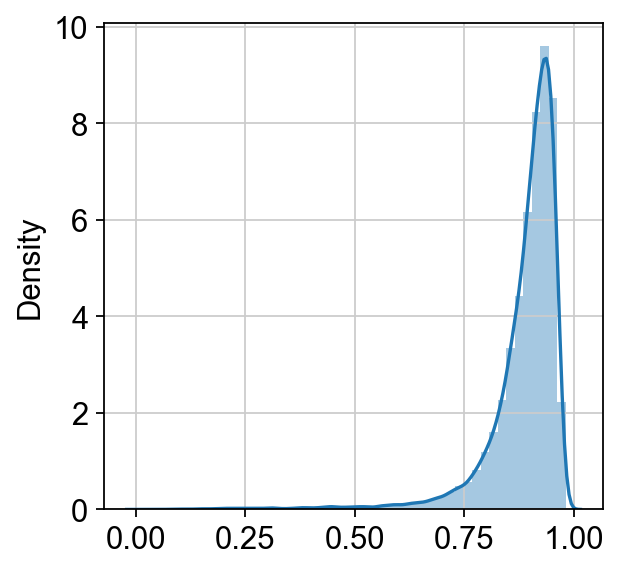

In [62]:
import umap
import seaborn as sns
from matplotlib import pyplot as plt
sns.distplot(Rs)
plt.savefig("/home/ssobti/projects/mir_tud/output_data/mave_output/MAVE_trial_triplet_loss_weight_1/recons_Rs.pdf")

In [63]:
from scipy.stats import spearmanr
Rhos = []
for i in range(len(reconst)):
    Rhos.append(spearmanr(arrayed_data[i,:], reconst[i,:])[0])

/tmp/ipykernel_1085698/2701172272.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Rhos)


<AxesSubplot: ylabel='Density'>

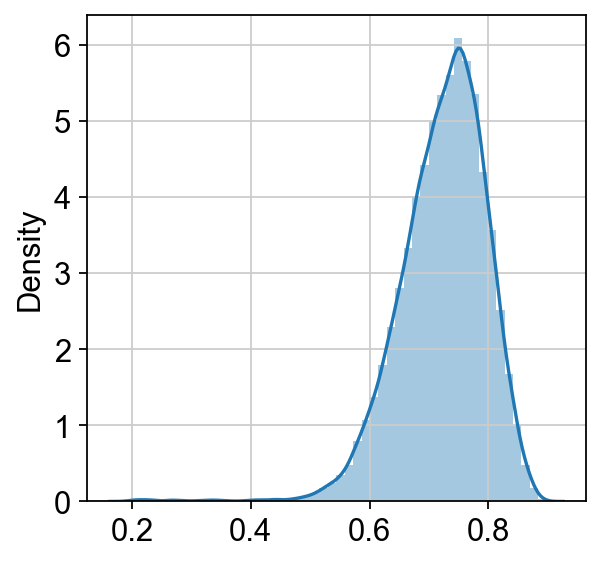

In [64]:
sns.distplot(Rhos)

In [65]:
mudf = pd.DataFrame(mumat)
mudf.columns = ["LV.mu.{}".format(each)
                            for each in range(numlvs)]

mudf.index = np.array(adata.obs.index, dtype="|U64")
mudf.head()

LV.mu.0   LV.mu.1   LV.mu.2   LV.mu.3   LV.mu.4  \
miR_1:AAACCCAAGGAGAGGC-1  0.174651  0.251674  0.530133 -0.049884  0.366395   
miR_1:AAACCCAAGGTAAACT-1  0.433475  0.466315  0.161894  0.102832  0.328492   
miR_1:AAACCCACAACGATCT-1  0.078461 -0.032440  0.053659  0.510955 -0.199917   
miR_1:AAACCCACACGATTCA-1  0.121964  0.220198  0.061406  0.779098  0.304534   
miR_1:AAACCCACAGTCAACT-1  0.599262  0.228409 -0.016199  0.066938  0.204585   

                           LV.mu.5   LV.mu.6   LV.mu.7   LV.mu.8   LV.mu.9  
miR_1:AAACCCAAGGAGAGGC-1 -0.611463  0.142948 -0.284557  0.064916  0.326886  
miR_1:AAACCCAAGGTAAACT-1 -0.219380 -0.215985  0.055600  0.546059  0.113377  
miR_1:AAACCCACAACGATCT-1 -0.208901 -0.110961  0.144197  0.305768  0.252394  
miR_1:AAACCCACACGATTCA-1 -0.468597  0.017969  0.004532  0.622730  0.204448  
miR_1:AAACCCACAGTCAACT-1 -0.315576 -0.013581 -0.586342  0.283705  0.193821

In [66]:
mudf.to_csv("/home/ssobti/projects/mir_tud/output_data/mave_output/MAVE_trial_triplet_loss_weight_1/scMAVE_mu-matrix.tsv.gz",
                compression="gzip", sep="\t")

In [67]:
mumat = np.array(mudf.iloc[:, :numlvs])
reducer = umap.UMAP(n_neighbors=10, min_dist=0.45)
embedding = reducer.fit_transform(mumat)
umap_output = pd.DataFrame(embedding)
umap_output.columns = ["UMAP1", "UMAP2"]
umap_output["guide"] = list(adata.obs["guide"])
umap_output.index = mudf.index
umap_output.head()

UMAP1     UMAP2            guide
miR_1:AAACCCAAGGAGAGGC-1  4.810398  4.536387  hsa-miR-203a-3p
miR_1:AAACCCAAGGTAAACT-1  2.948831  0.986553    hsa-miR-93-3p
miR_1:AAACCCACAACGATCT-1  2.671752  5.654237  hsa-miR-130b-3p
miR_1:AAACCCACACGATTCA-1  3.922816  4.762352        TuD_NC_18
miR_1:AAACCCACAGTCAACT-1  7.643917  2.686160  hsa-miR-147b-5p

In [68]:
umap_output.to_csv("/home/ssobti/projects/mir_tud/output_data/mave_output/MAVE_trial_triplet_loss_weight_1/UMAP-OF-MU.tsv.gz",sep="\t", compression="gzip")

In [69]:
import pandas as pd
import seaborn as sns
import numpy as np

umap_output = pd.read_csv("/home/ssobti/projects/mir_tud/output_data/mave_output/MAVE_trial_triplet_loss_weight_1/UMAP-OF-MU.tsv.gz", sep = '\t')
umap_output

Unnamed: 0     UMAP1     UMAP2             guide
0      miR_1:AAACCCAAGGAGAGGC-1  4.810398  4.536387   hsa-miR-203a-3p
1      miR_1:AAACCCAAGGTAAACT-1  2.948831  0.986553     hsa-miR-93-3p
2      miR_1:AAACCCACAACGATCT-1  2.671752  5.654237   hsa-miR-130b-3p
3      miR_1:AAACCCACACGATTCA-1  3.922816  4.762352         TuD_NC_18
4      miR_1:AAACCCACAGTCAACT-1  7.643917  2.686160   hsa-miR-147b-5p
...                         ...       ...       ...               ...
29142  miR_3:TTTGGTTTCGGACTTA-1  3.356622  2.754817    hsa-miR-616-5p
29143  miR_3:TTTGTTGCACGCGTGT-1  6.676410  3.281885    hsa-miR-361-5p
29144  miR_3:TTTGTTGCATAGATCC-1  5.412015  8.593673   hsa-miR-548o-3p
29145  miR_3:TTTGTTGGTCTAGTGT-1  6.221900  8.361196   hsa-miR-3940-5p
29146  miR_3:TTTGTTGGTTTCCATT-1  7.470965  1.884333  hsa-miR-10527-5p

[29147 rows x 4 columns]

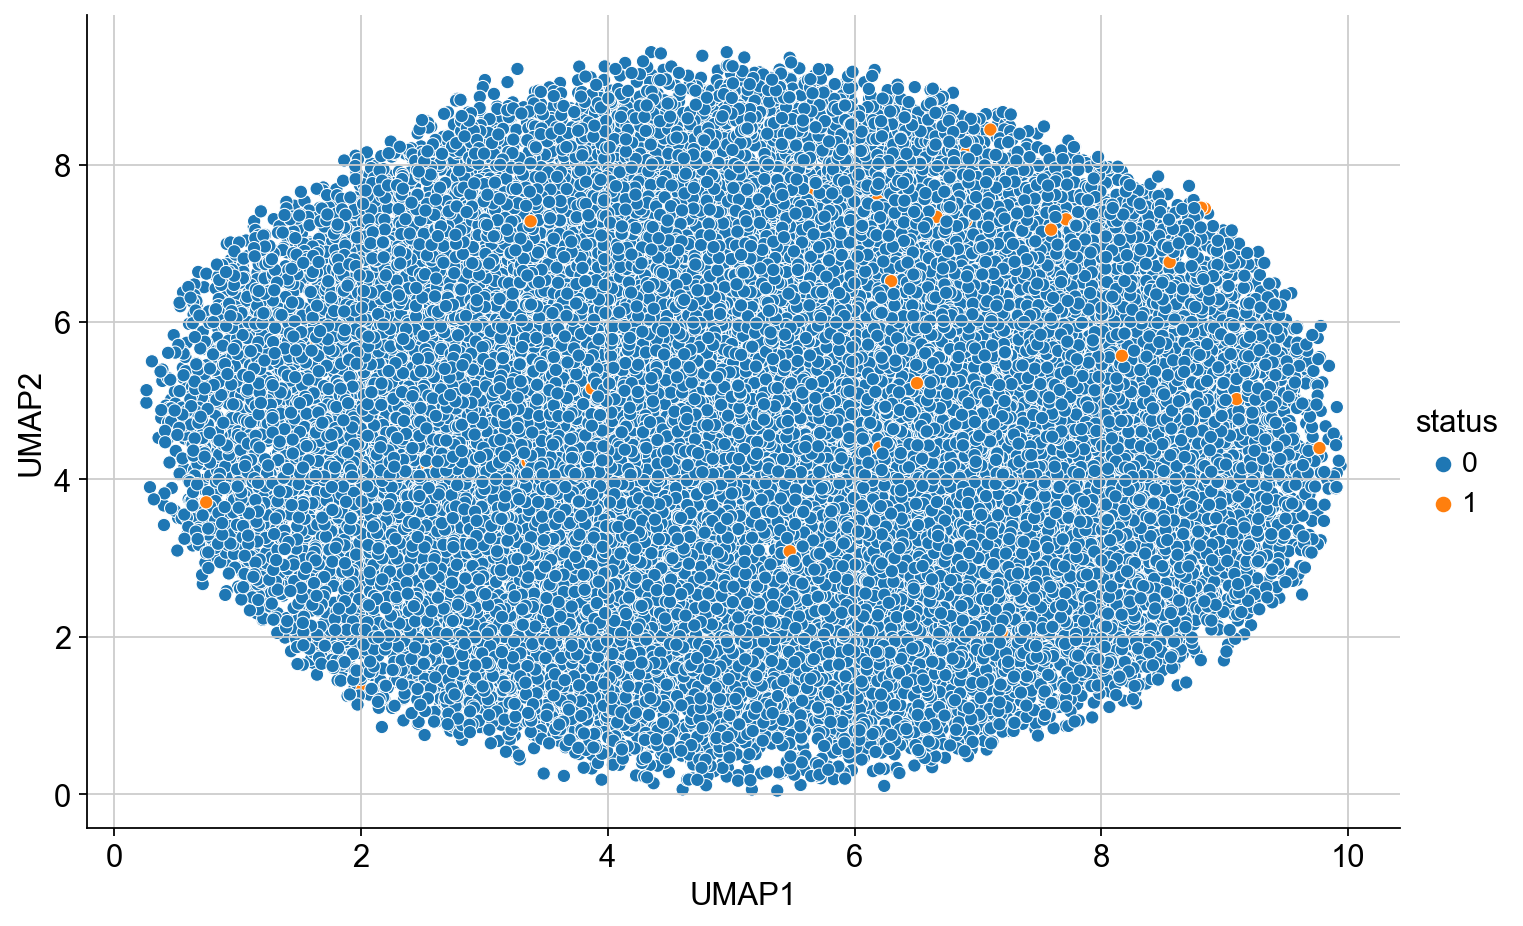

In [70]:
umap_output['status'] = np.where(umap_output.guide=="TuD_NC_04", 1, 0)
sns_plot = sns.relplot(
    x="UMAP1", y="UMAP2", hue="status", data=umap_output,
    height=6, aspect=1.5)

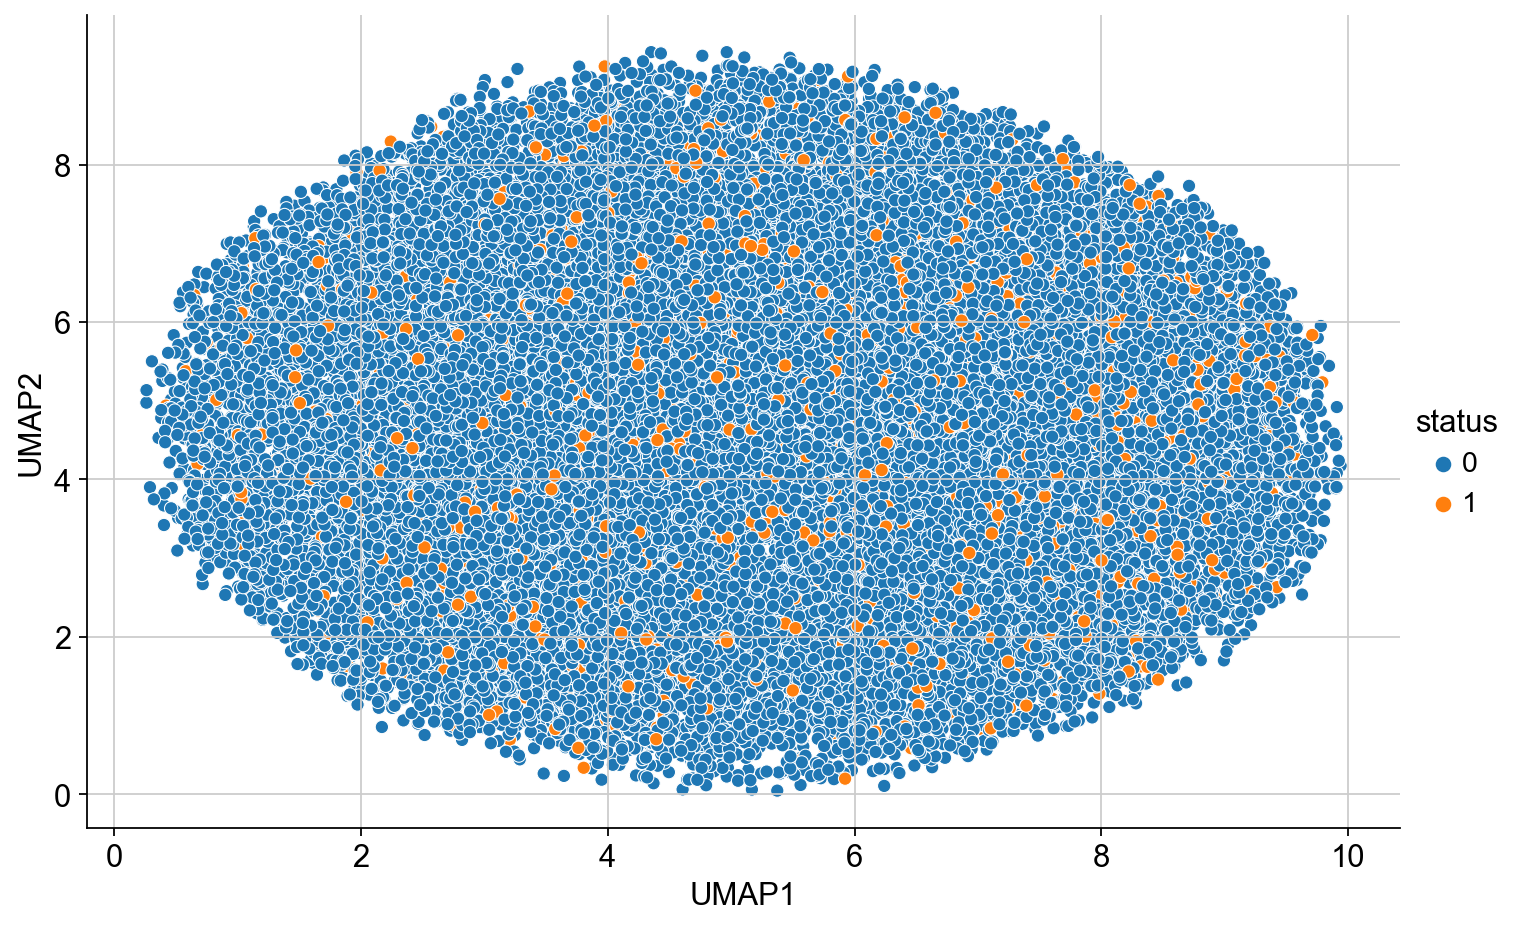

In [71]:
umap_output['status'] = np.where(umap_output.guide=="TuD_NC_01", 1, 0)
sns_plot = sns.relplot(
    x="UMAP1", y="UMAP2", hue="status", data=umap_output,
    height=6, aspect=1.5)

In [72]:
merged = mudf.merge(adata.obs[["guide"]], left_index=True, right_index=True).groupby(["guide"]).median()
merged.head()

LV.mu.0   LV.mu.1   LV.mu.2   LV.mu.3   LV.mu.4   LV.mu.5  \
guide                                                                   
TuD_NC_01  0.139377  0.273490  0.206942  0.287194  0.245290 -0.312597   
TuD_NC_02  0.161435  0.204085  0.384478  0.249403  0.389765 -0.212445   
TuD_NC_03  0.194632  0.280121  0.198445  0.183058  0.306263 -0.212402   
TuD_NC_04  0.181318  0.114492  0.094363  0.387531  0.266471 -0.333994   
TuD_NC_05  0.146288  0.330926  0.199847  0.182840  0.278453 -0.277683   

            LV.mu.6   LV.mu.7   LV.mu.8   LV.mu.9  
guide                                              
TuD_NC_01 -0.243239 -0.242288  0.261630  0.281020  
TuD_NC_02 -0.174202 -0.138629  0.215379  0.272180  
TuD_NC_03 -0.231537 -0.230872  0.256744  0.196510  
TuD_NC_04 -0.258852 -0.363670  0.197897  0.368772  
TuD_NC_05 -0.125948 -0.234631  0.312556  0.307901

In [73]:
merged.loc["TuD_NC_01", ]

LV.mu.0    0.139377
LV.mu.1    0.273490
LV.mu.2    0.206942
LV.mu.3    0.287194
LV.mu.4    0.245290
LV.mu.5   -0.312597
LV.mu.6   -0.243239
LV.mu.7   -0.242288
LV.mu.8    0.261630
LV.mu.9    0.281020
Name: TuD_NC_01, dtype: float64

In [74]:
#set negative as origin
merged = merged - merged.loc["TuD_NC_01", ]
merged.drop("TuD_NC_01", axis=0, inplace=True)

/home/ssobti/miniconda3/envs/mave/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ssobti/miniconda3/envs/mave/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


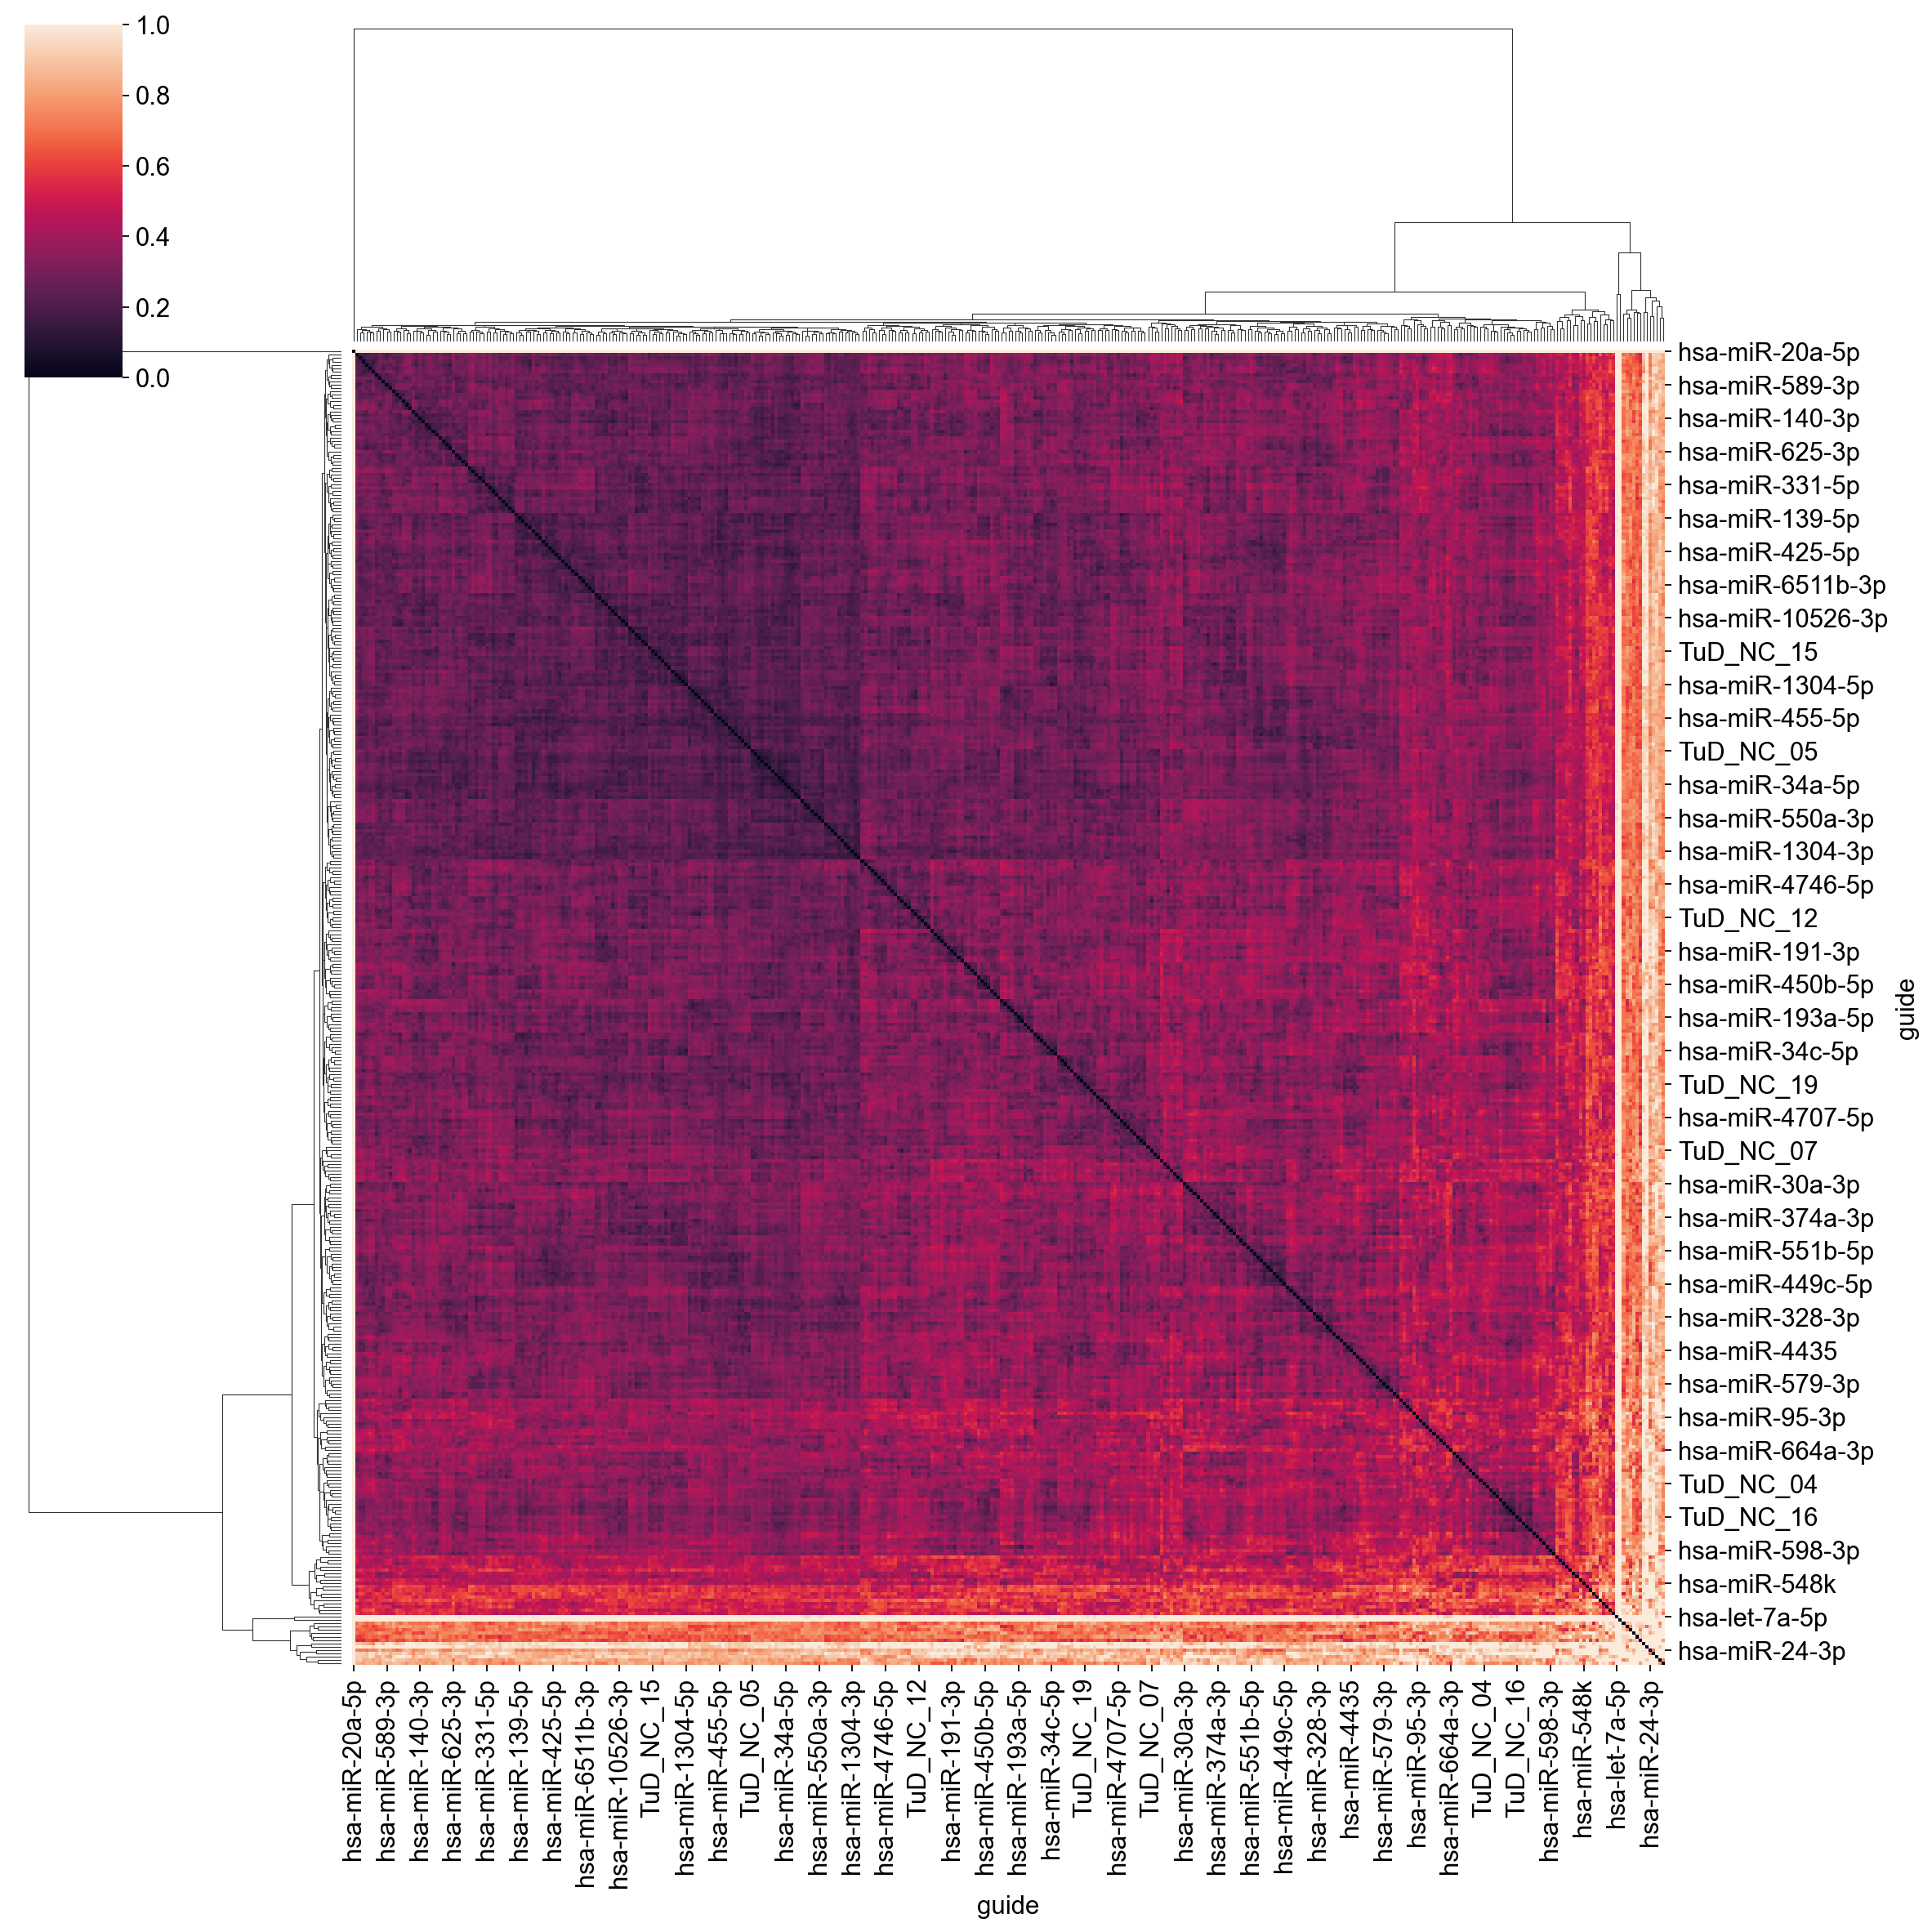

In [75]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

sns.clustermap(pd.DataFrame(squareform(pdist(merged)), index=merged.index, columns=merged.index), vmax=1, figsize=(15,15))
plt.savefig("/home/ssobti/projects/mir_tud/output_data/mave_output/MAVE_trial_triplet_loss_weight_1/mudf_pairwise_distance.pdf")

In [76]:
pd.DataFrame(squareform(pdist(merged)), index=merged.index, columns=merged.index).to_csv("/home/ssobti/projects/mir_tud/output_data/mave_output/MAVE_trial_triplet_loss_weight_1/mudf_pairwise_distance.tsv", sep="\t")

In [77]:
!head /home/ssobti/projects/mir_tud/output_data/mave_output/MAVE_trial_triplet_loss_weight_1/mudf_pairwise_distance.tsv

guide	TuD_NC_02	TuD_NC_03	TuD_NC_04	TuD_NC_05	TuD_NC_06	TuD_NC_07	TuD_NC_08	TuD_NC_09	TuD_NC_10	TuD_NC_11	TuD_NC_12	TuD_NC_13	TuD_NC_14	TuD_NC_15	TuD_NC_16	TuD_NC_17	TuD_NC_18	TuD_NC_19	TuD_NC_20	hsa-let-7a-2-3p	hsa-let-7a-5p	hsa-let-7b-3p	hsa-let-7d-3p	hsa-let-7f-2-3p	hsa-let-7i-3p	hsa-let-7i-5p	hsa-miR-7-1-3p	hsa-miR-7-5p	hsa-miR-9-3p	hsa-miR-9-5p	hsa-miR-10a-3p	hsa-miR-10a-5p	hsa-miR-15a-5p	hsa-miR-15b-3p	hsa-miR-15b-5p	hsa-miR-16-2-3p	hsa-miR-16-5p	hsa-miR-17-3p	hsa-miR-18a-3p	hsa-miR-18a-5p	hsa-miR-19b-1-5p	hsa-miR-19b-3p	hsa-miR-20a-3p	hsa-miR-20a-5p	hsa-miR-21-3p	hsa-miR-21-5p	hsa-miR-22-3p	hsa-miR-22-5p	hsa-miR-23a-5p	hsa-miR-23b-3p	hsa-miR-23b-5p	hsa-miR-24-1-5p	hsa-miR-24-2-5p	hsa-miR-24-3p	hsa-miR-25-3p	hsa-miR-25-5p	hsa-miR-26a-1-3p	hsa-miR-26a-2-3p	hsa-miR-26a-5p	hsa-miR-27a-5p	hsa-miR-27b-3p	hsa-miR-27b-5p	hsa-miR-28-3p	hsa-miR-28-5p	hsa-miR-29a-3p	hsa-miR-29a-5p	hsa-miR-29b-1-5p	hsa-miR-29b-3p	hsa-miR-29c-5p	hsa-miR-30a-3p	hsa-miR-30a-5p	hsa-miR-30b-3p	hsa-miR-30c-1-3p	h

/home/ssobti/miniconda3/envs/mave/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


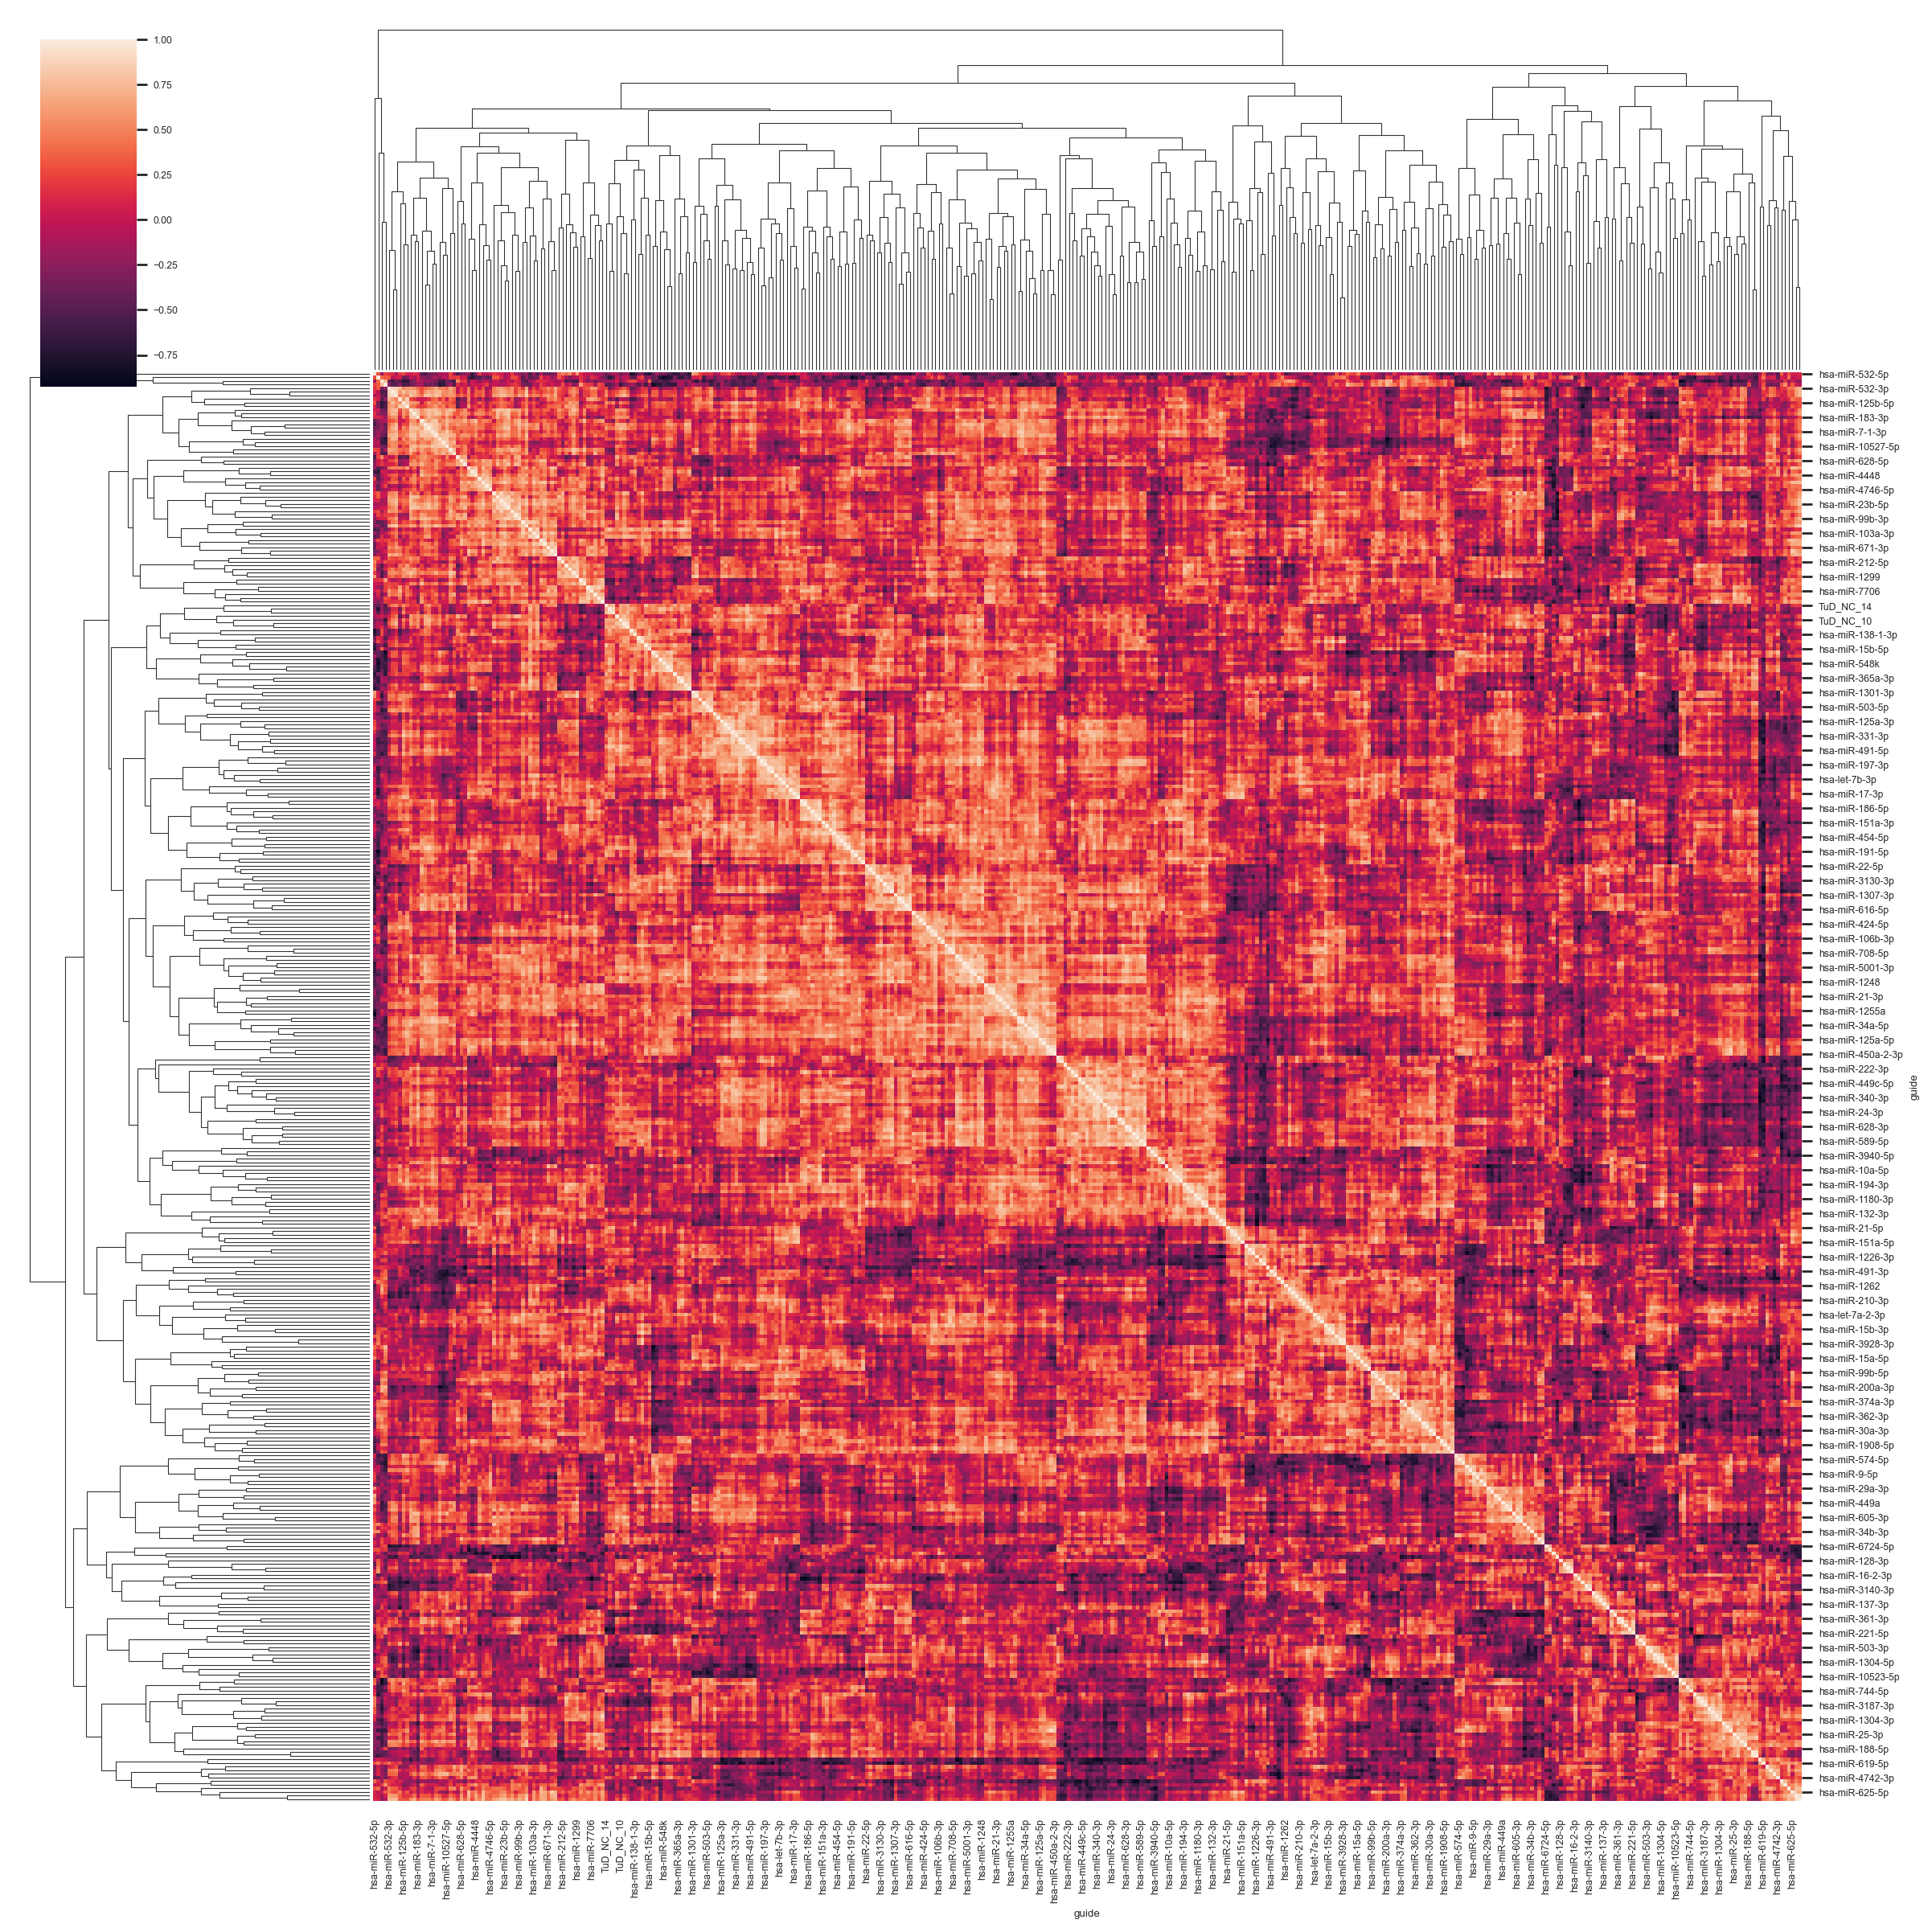

In [78]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=0.5)
sns.clustermap(merged.T.corr(), figsize=(15,15))
plt.savefig("/home/ssobti/projects/mir_tud/output_data/mave_output/MAVE_trial_triplet_loss_weight_1/mudf_corr.pdf")

In [79]:
gmtmat_df.shape

(19073, 3725)

In [80]:
rbpdf = pd.DataFrame(rbp_act, columns=gmtmat_df.columns)
rbpdf.index = np.array(adata.obs.index, dtype="|U64")
rbpdf.head()

MIR153_5P   MIR8485   MIR3662    MIR607  MIR616_5P  \
miR_1:AAACCCAAGGAGAGGC-1   0.210479 -0.072204  0.385821  0.189051   1.007321   
miR_1:AAACCCAAGGTAAACT-1   0.912333 -0.295524  0.216528 -0.261120  -0.278642   
miR_1:AAACCCACAACGATCT-1   1.241695 -0.444833  0.681181 -0.908265   0.500594   
miR_1:AAACCCACACGATTCA-1   0.867060 -0.578300  0.238871 -0.008522   0.636098   
miR_1:AAACCCACAGTCAACT-1   0.623977 -0.126903  1.063738 -0.052309  -0.088283   

                          MIR371B_5P  MIR373_5P  MIR6867_5P  MIR12136  \
miR_1:AAACCCAAGGAGAGGC-1   -0.685000   1.007222   -0.799619  0.879210   
miR_1:AAACCCAAGGTAAACT-1   -0.662183   0.673514   -0.669319  0.280752   
miR_1:AAACCCACAACGATCT-1   -0.680937   0.675588   -0.999006  0.406025   
miR_1:AAACCCACACGATTCA-1   -0.452332   0.462298   -1.255017  0.696791   
miR_1:AAACCCACAGTCAACT-1    0.022900   0.933875   -0.562763 -0.460977   

                          MIR548AJ_3P_MIR548X_3P  ...  E2F1DP1RB_01  \
miR_1:AAACCCAAGGAGAGGC-1                0.200197  ...     -1.295421   
miR_1:AAACCCAAGGTAAACT-1                0.088641  ...     -1.174745   
miR_1:AAACCCACAACGATCT-1               -0.279223  ...     -1.588932   
miR_1:AAACCCACACGATTCA-1                0.179155  ...     -1.759405   
miR_1:AAACCCACAGTCAACT-1               -0.285237  ...     -0.917915   

                          E2F_Q3_01  E2F_Q4_01  E2F_Q6_01  E2F1_Q3_01  \
miR_1:AAACCCAAGGAGAGGC-1   2.386066   1.083849  -0.575910    0.129041   
miR_1:AAACCCAAGGTAAACT-1   1.628772   0.871731  -0.461141   -0.034874   
miR_1:AAACCCACAACGATCT-1   2.947020   1.453380  -0.664849    0.179409   
miR_1:AAACCCACACGATTCA-1   3.712438   1.158160  -0.767486    0.207014   
miR_1:AAACCCACAGTCAACT-1   1.089295   0.157356  -0.602944    0.102586   

                          E2F1_Q4_01  E2F1_Q6_01  KTGGYRSGAA_UNKNOWN  \
miR_1:AAACCCAAGGAGAGGC-1   -1.474154    0.475306           -0.125077   
miR_1:AAACCCAAGGTAAACT-1   -0.943387    0.943412            0.031974   
miR_1:AAACCCACAACGATCT-1   -2.018857    1.412127            0.063446   
miR_1:AAACCCACACGATTCA-1   -1.506017    2.034970            0.070222   
miR_1:AAACCCACAGTCAACT-1   -0.596022    1.323229            0.034679   

                          RRCCGTTA_UNKNOWN  SGCGSSAAA_E2F1DP2_01  
miR_1:AAACCCAAGGAGAGGC-1          0.359037             -0.064615  
miR_1:AAACCCAAGGTAAACT-1         -0.066550              0.090736  
miR_1:AAACCCACAACGATCT-1         -0.325228             -0.010576  
miR_1:AAACCCACACGATTCA-1         -0.038187             -0.121896  
miR_1:AAACCCACAGTCAACT-1          0.064628             -0.215998  

[5 rows x 3725 columns]

In [81]:
merged = rbpdf.merge(adata.obs[["guide"]], left_index=True, right_index=True).groupby(["guide"]).median()
merged.head()

MIR153_5P   MIR8485   MIR3662    MIR607  MIR616_5P  MIR371B_5P  \
guide                                                                       
TuD_NC_01   0.651812 -0.378862  0.330495 -0.067971   0.391959   -0.392789   
TuD_NC_02   0.839627 -0.425424  0.358680  0.020034   0.492717   -0.350722   
TuD_NC_03   0.724231 -0.429038  0.424133  0.033965   0.376377   -0.402825   
TuD_NC_04   0.741831 -0.492888  0.379391 -0.067854   0.367369   -0.414564   
TuD_NC_05   0.714136 -0.420883  0.364346 -0.056582   0.364027   -0.378697   

           MIR373_5P  MIR6867_5P  MIR12136  MIR548AJ_3P_MIR548X_3P  ...  \
guide                                                               ...   
TuD_NC_01   0.724196   -0.872699  0.698340                0.200198  ...   
TuD_NC_02   0.805745   -1.004289  0.746349                0.264514  ...   
TuD_NC_03   0.666429   -0.884581  0.613594                0.223989  ...   
TuD_NC_04   0.657475   -0.871697  0.593626                0.227888  ...   
TuD_NC_05   0.784002   -0.886622  0.771030                0.205564  ...   

           E2F1DP1RB_01  E2F_Q3_01  E2F_Q4_01  E2F_Q6_01  E2F1_Q3_01  \
guide                                                                  
TuD_NC_01     -1.435818   2.403318   0.782278  -0.460330    0.118483   
TuD_NC_02     -1.551324   2.564175   0.799955  -0.572822    0.138698   
TuD_NC_03     -1.487414   2.609080   0.839051  -0.473905    0.119616   
TuD_NC_04     -1.524372   2.569010   0.811909  -0.487069    0.125394   
TuD_NC_05     -1.432233   2.235388   0.792685  -0.507853    0.091834   

           E2F1_Q4_01  E2F1_Q6_01  KTGGYRSGAA_UNKNOWN  RRCCGTTA_UNKNOWN  \
guide                                                                     
TuD_NC_01   -1.484797    1.231800           -0.010773          0.053385   
TuD_NC_02   -1.600604    1.500417           -0.026995          0.040046   
TuD_NC_03   -1.616296    1.276018           -0.013092          0.063649   
TuD_NC_04   -1.535444    1.425796            0.007111          0.026726   
TuD_NC_05   -1.602663    1.274525           -0.021953          0.069721   

           SGCGSSAAA_E2F1DP2_01  
guide                            
TuD_NC_01             -0.081651  
TuD_NC_02             -0.115749  
TuD_NC_03             -0.086382  
TuD_NC_04             -0.090340  
TuD_NC_05             -0.048242  

[5 rows x 3725 columns]

/home/ssobti/miniconda3/envs/mave/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


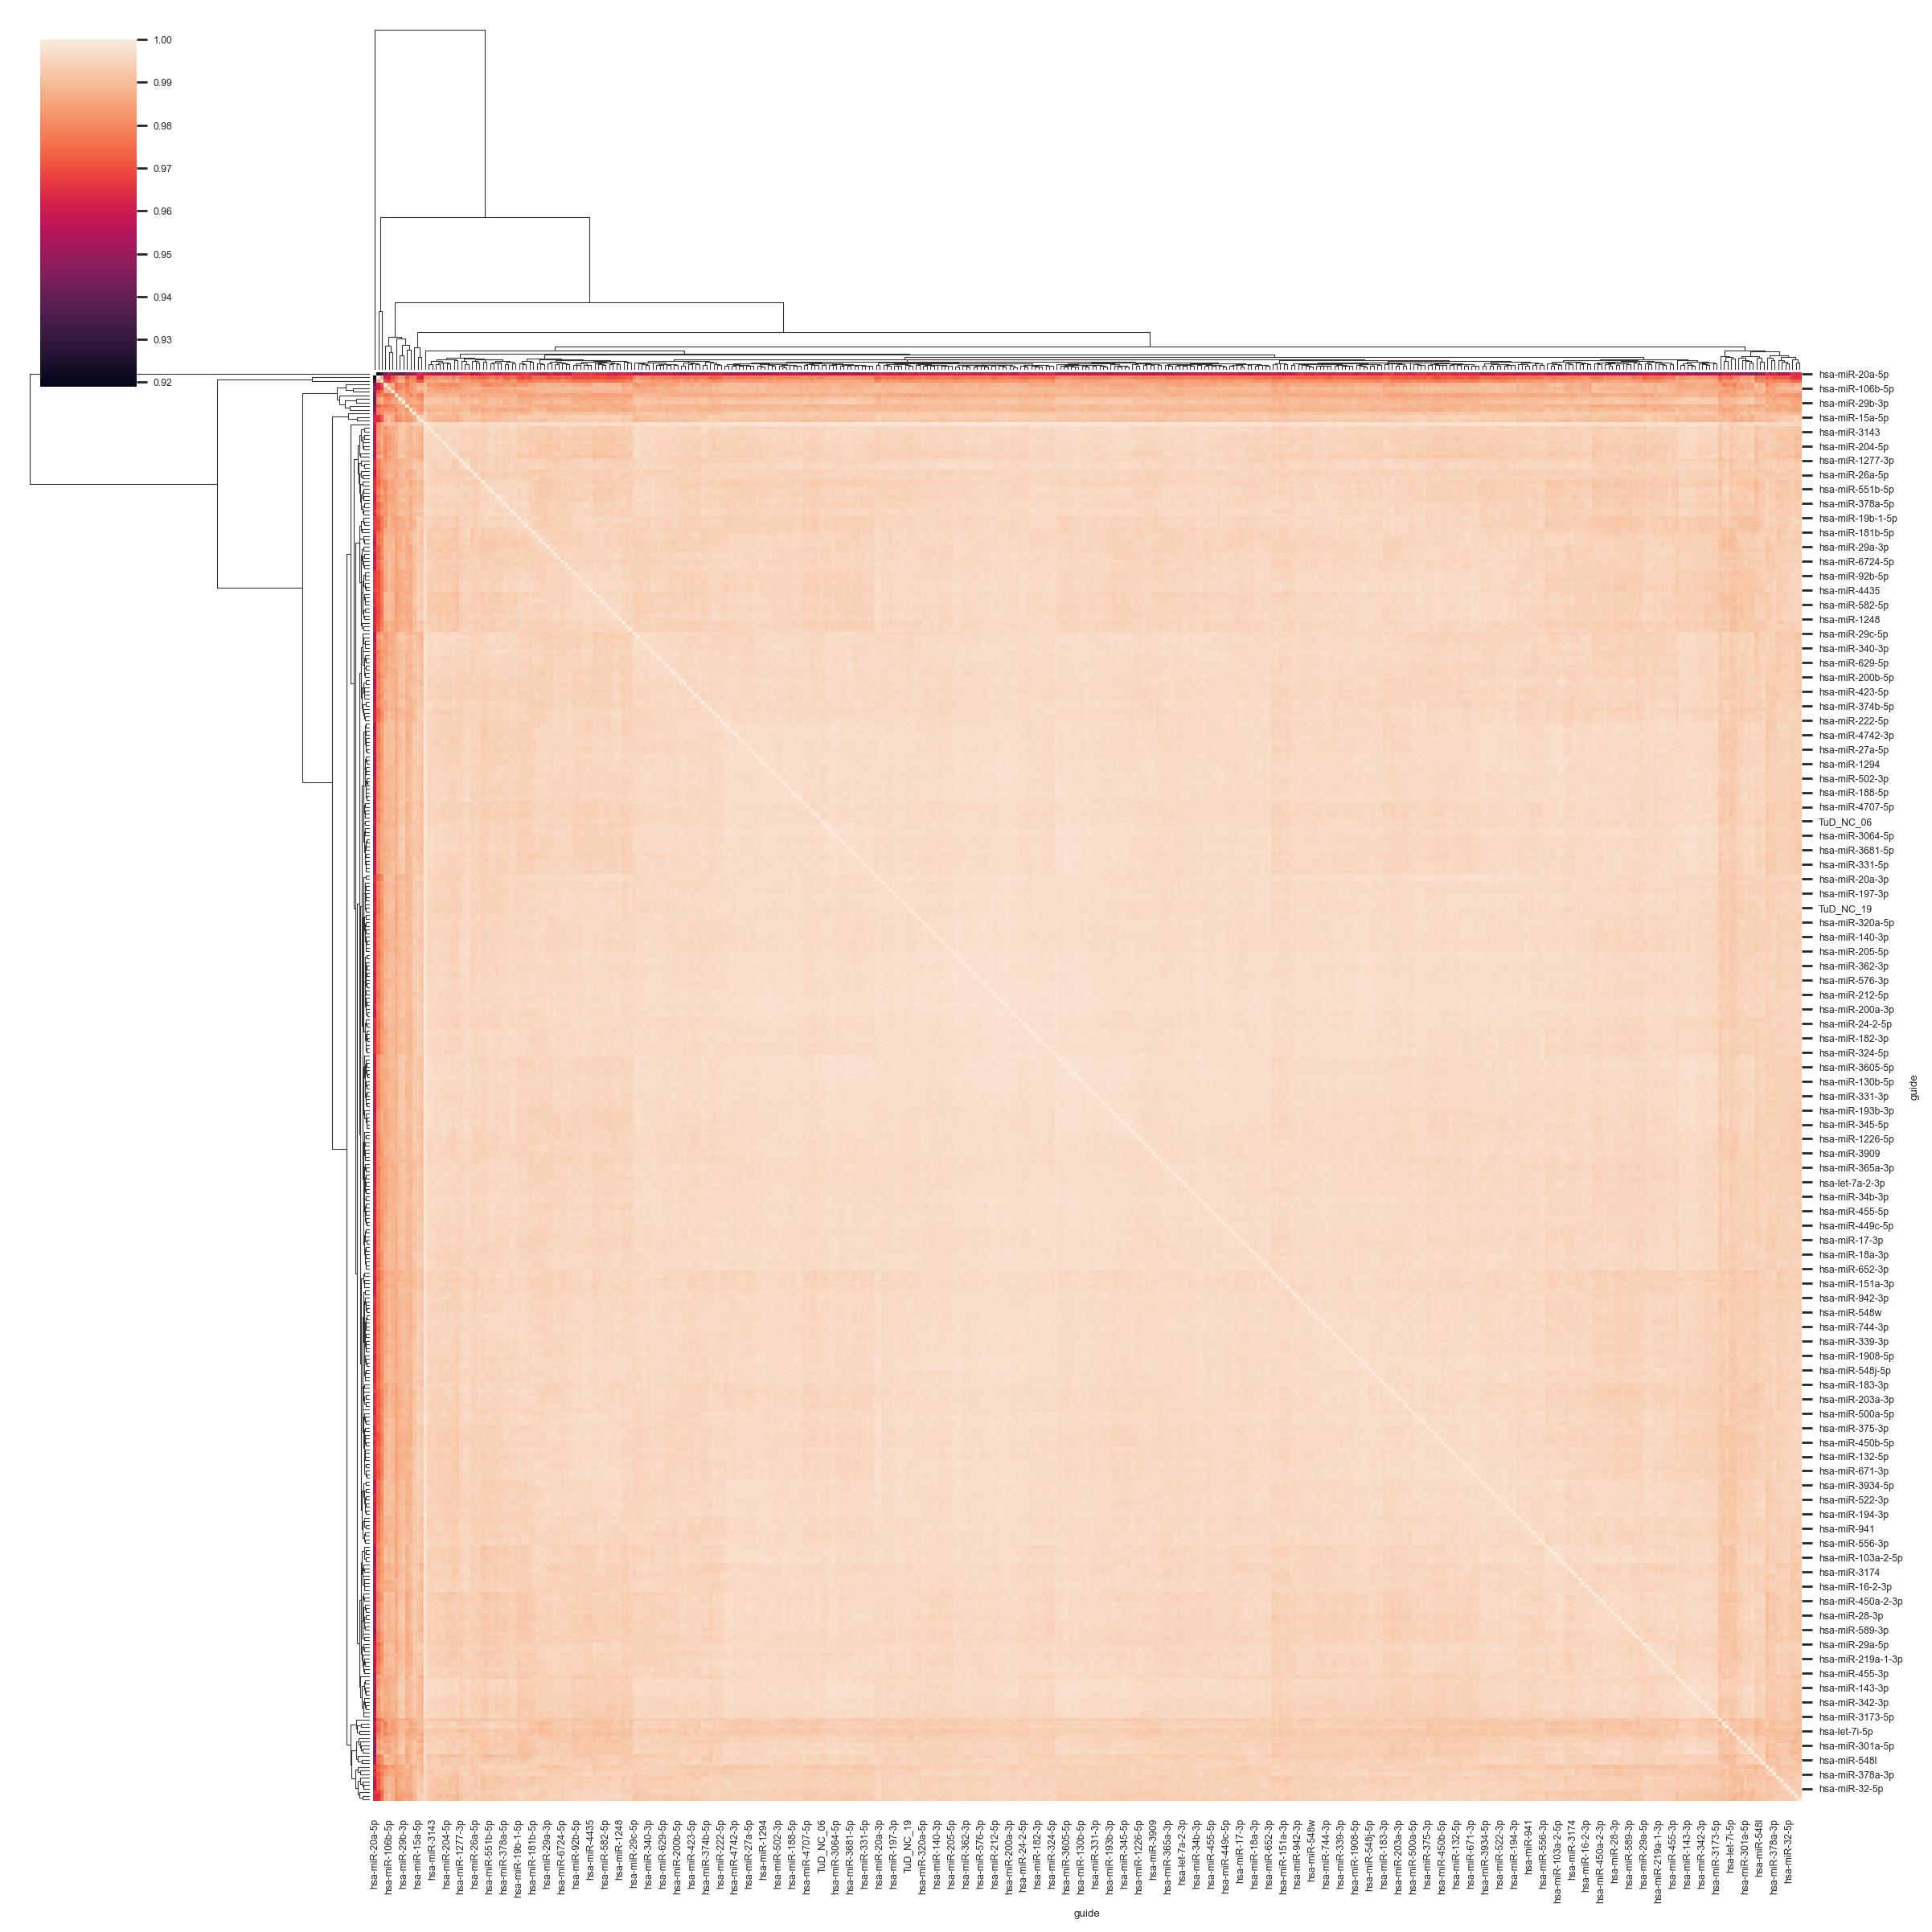

In [82]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=0.5)
sns.clustermap(merged.T.corr(), figsize=(15,15))
plt.savefig("/home/ssobti/projects/mir_tud/output_data/mave_output/MAVE_trial_triplet_loss_weight_1/rbpdf_corr.pdf")